# Final
Using ML models to describe and predict the weather is common, but there is a gap in research related to predicting increasingly common ‘extreme weather events’ (Watson 2022). For climate models to be useful they must perform well in extreme situations.
In this project I will train various ML models to predict days to be either normal or anomalous, in terms of their max temperature. I formated this problem into a classification problem.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors



In [2]:
#Loading in the data
NYC = pd.read_csv("NYC.csv", index_col="DATE")
print('NYC Shape: ', NYC.shape)
NYC

NYC Shape:  (15707, 45)


,STATION,NAME,ACMH,ACSH,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,...,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22,WV01
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.0,60.0,NaN,NaN,1036.0,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",50.0,50.0,NaN,NaN,954.0,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",10.0,20.0,NaN,NaN,1912.0,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",70.0,90.0,NaN,NaN,2230.0,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1980-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",100.0,100.0,NaN,NaN,1418.0,0.09,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",NaN,NaN,8.50,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",NaN,NaN,7.16,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",NaN,NaN,6.26,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocessing 

We first find the percentage of null values in each feature

In [3]:
nyc_null_pct = NYC.apply(pd.isnull).sum()/NYC.shape[0]


In [4]:
display(pd.concat([ nyc_null_pct], axis=1))
#Here is all the features and the percent of samples that are null

,0
STATION,0.000000
NAME,0.000000
ACMH,0.620360
ACSH,0.620297
AWND,0.093143
FMTM,0.355447
PGTM,0.319348
PRCP,0.000000
SNOW,0.000000
SNWD,0.000000


### Handling WT**( Weather Type) features
Although the WT** columns seem to be majority null, it is because those columns place a 1 if on that day the weather indicated by the 2 numbers after the WT(i.e. 01 means fog, 05 means hail, 17 means freezing rain), and leave the space empty if the weather doesn't occur that day. I feel these are important features, so I'm going to place a 0 in the null values of those feature, so 1 means that type of weather occured, and 0 means it didn't. Same with the WV**(Weather in the vicinity) features.

In [5]:
nyc_wt_columns = NYC.filter(regex='WT|WV')
NYC[nyc_wt_columns.columns] = NYC[nyc_wt_columns.columns].fillna(0)


In [6]:
nyc_null_pct = NYC.apply(pd.isnull).sum()/NYC.shape[0]


In [7]:
display(pd.concat([nyc_null_pct], axis=1))

,0
STATION,0.000000
NAME,0.000000
ACMH,0.620360
ACSH,0.620297
AWND,0.093143
FMTM,0.355447
PGTM,0.319348
PRCP,0.000000
SNOW,0.000000
SNWD,0.000000


Now we have the WT and WV features totally filled out, lets see what features are still full of null values

In [8]:
NYC_bad = nyc_null_pct[nyc_null_pct> 0.5]


In [9]:
NYC_bad

ACMH    0.620360
ACSH    0.620297
TAVG    0.602980
TSUN    0.998154
WDF1    0.620615
WDFG    0.673967
WDFM    0.999936
WESD    0.619214
WSF1    0.620424
WSFG    0.625199
WSFM    0.999936
dtype: float64

In [10]:
display(pd.concat([ NYC_bad], axis=1))

,0
ACMH,0.620360
ACSH,0.620297
TAVG,0.602980
TSUN,0.998154
WDF1,0.620615
WDFG,0.673967
WDFM,0.999936
WESD,0.619214
WSF1,0.620424
WSFG,0.625199


### These features are:


~~ACMH = Average cloudiness midnight to midnight from manual observations (percent)~~  
Not important 

~~ACSH = Average cloudiness sunrise to sunset from manual observations (percent)~~  
Not important

~~DAPR = Number of days included in the multiday precipitation total (MDPR)~~  
Not important

~~DASF = Number of days included in the multiday snowfall total (MDSF)~~  
Not important

~~FMTM = Time of fastest mile or fastest 1-minute wind (hours and minutes, i.e., HHMM)~~
Time data wont fit into the model well


SNOW = Snowfall (mm or inches as per user preference, inches to tenths on Daily Form pdf file)  
We should keep this, although there isn't alot of data for la there is a lot for nyc

SNWD = Snow depth (mm or inches as per user preference, inches on Daily Form pdf file)  
We should keep this, although there isn't alot of data for la there is a lot for nyc


~~TAVG = Average temperature~~. 
there just isn't enough samples 

~~TOBS = Temperature at the time of observation (Fahrenheit or Celsius as per user preference)~~  
there just isn't enough samples 


~~TSUN = Daily total sunshine (minutes)~~. 
there just isn't enough samples 

~~WDF1 = Direction of fastest 1-minute wind (degrees)~~. 
direction data won't fit well into a model

~~WDFG = Direction of peak wind gust (degrees)~~. 
direction data won't fit well into a model


~~WESD = Water equivalent of snow on the ground (inches or mm as per user preference)~~. 
This is not that different from precipitation 

~~WSF1 = Fastest 1-minute wind speed (miles per hour or meters per second as per user preference)~~. 
to0 similar to the second wind second feature 

WSFG = Peak guest wind speed (miles per hour or meters per second as per user preference)  
This is important, but around 1996 stations switched their labels, and started recording WSFG as WSF5( or fastest 5 second wind speed(NYC: 1996-04-30| LA:1997-03-03), so I'll organize all the samples into 1 column


~~WDFM = Fastest mile wind direction (degrees)~~   
direction data won't fit well into a model


~~WSFM = Fastest mile wind speed (miles per hour or meters per second as per user preference)~~. 
Not needed


I am also going to delete any features that are time based:

PGTM = Peak gust time (hours and minutes, i.e., HHMM)



Which of these feature are we gonna get rid of, and what should we replace the null values with 0s

Above I figuree out some of the features I'm going to delete, I will do it outside of python because it is easier,
The updated dataset is called NYC-updated
### Now lets look at the updated datasets

In [11]:
NYC_updated = pd.read_csv("NYC-updated.csv", index_col="DATE")
print('NYC Shape: ', NYC_updated.shape)



NYC Shape:  (15707, 25)


In [12]:
nyc_null = NYC_updated.apply(pd.isnull).sum()/NYC_updated.shape[0]
#Finding the percentage of null values in each column

In [13]:
display(pd.concat([ nyc_null], axis=1))

,0
STATION,0.000000
NAME,0.000000
AWND,0.093143
PRCP,0.000000
SNOW,0.000000
SNWD,0.000000
TMAX,0.000000
TMIN,0.000000
WSFG,0.010314
WT01,0.618387


### Handling the nulls in the remaining features 
So now we have 25 features in both the NYC dataset, although many still have a good deal of null values. We know how to handle the nulls for the WT and WV features, but how about the others? 

##### WT | WV feature null handling

In [14]:
nyc_wtwv_columns = NYC_updated.filter(regex='WT|WV')
NYC_updated[nyc_wtwv_columns.columns] = NYC_updated[nyc_wtwv_columns.columns].fillna(0)


In [15]:
 NYC_updated

,STATION,NAME,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WSFG,WT01,...,WT07,WT08,WT09,WT11,WT13,WT14,WT16,WT18,WT21,WV01
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",NaN,0.00,0.0,0.0,42,26,11.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",NaN,0.00,0.0,0.0,41,31,32.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",NaN,0.00,0.0,0.0,36,28,20.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",NaN,0.00,0.0,0.0,30,20,21.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1980-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",NaN,0.09,3.0,2.0,29,25,36.7,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",8.50,0.00,0.0,0.0,45,27,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-29,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",7.16,0.00,0.0,0.0,46,32,18.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-30,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",6.26,0.00,0.0,0.0,51,34,15.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now lets look at the remaining features with null values

In [16]:
nyc_null = NYC_updated.apply(pd.isnull).sum()/NYC_updated.shape[0]

display(pd.concat([ nyc_null], axis=1))

,0
STATION,0.000000
NAME,0.000000
AWND,0.093143
PRCP,0.000000
SNOW,0.000000
SNWD,0.000000
TMAX,0.000000
TMIN,0.000000
WSFG,0.010314
WT01,0.000000


### The remaining columns with null features are:

AWND = Average daily wind speed (meters per second or miles per hour as per user preference)

SNOW = Snowfall (mm or inches as per user preference, inches to tenths on Daily Form pdf file)  
FOR LA

SNWD = Snow depth (mm or inches as per user preference, inches on Daily Form pdf file)  
FOR LA

WSFG = Peak guest wind speed (miles per hour or meters per second as per user preference)





### How will we fill the null values?

For AWND, I think it will be best to use the average of the data set

For SNOW, I think its safe to assume 0 for the null values, especially because there are only null values in the LA dataset

For SNWD, same as SNOW

For WSFG, I think we can use the average of the dataset

In [17]:
NYC_updated[['AWND', 'WSFG']]= NYC_updated[['AWND', 'WSFG']].fillna(NYC_updated[['AWND', 'WSFG']].mean())


In [18]:
NYC_updated


,STATION,NAME,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WSFG,WT01,...,WT07,WT08,WT09,WT11,WT13,WT14,WT16,WT18,WT21,WV01
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",11.237327,0.00,0.0,0.0,42,26,11.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",11.237327,0.00,0.0,0.0,41,31,32.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",11.237327,0.00,0.0,0.0,36,28,20.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",11.237327,0.00,0.0,0.0,30,20,21.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1980-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",11.237327,0.09,3.0,2.0,29,25,36.7,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",8.500000,0.00,0.0,0.0,45,27,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-29,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",7.160000,0.00,0.0,0.0,46,32,18.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-30,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",6.260000,0.00,0.0,0.0,51,34,15.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
NYC_updated[['SNOW', 'SNWD']]= NYC_updated[['SNOW', 'SNWD']].fillna(0)


In [107]:
NYC_updated.apply(pd.isnull).sum()

STATION    0
NAME       0
AWND       0
PRCP       0
SNOW       0
SNWD       0
TMAX       0
TMIN       0
WSFG       0
WT01       0
WT02       0
WT03       0
WT04       0
WT05       0
WT06       0
WT07       0
WT08       0
WT09       0
WT11       0
WT13       0
WT14       0
WT16       0
WT18       0
WT21       0
WV01       0
Target     0
dtype: int64

### Complete Dataset
now we have a complete dataset with no null values,

Lets check the datatypes of the data

In [108]:
NYC_updated.dtypes

STATION     object
NAME        object
AWND       float64
PRCP       float64
SNOW       float64
SNWD       float64
TMAX         int64
TMIN         int64
WSFG       float64
WT01       float64
WT02       float64
WT03       float64
WT04       float64
WT05       float64
WT06       float64
WT07       float64
WT08       float64
WT09       float64
WT11       float64
WT13       float64
WT14       float64
WT16       float64
WT18       float64
WT21       float64
WV01       float64
Target       int64
dtype: object

We can see that all the features floats or ints, except for the NAME and STATION, which are strings. That is what we want. Now lets save the index as a date time

In [109]:
NYC_updated.index = pd.to_datetime(NYC_updated.index)


### Exploring the Data
NYC_updated



In [110]:
NYC_updated.columns

Index(['STATION', 'NAME', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN',
       'WSFG', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08',
       'WT09', 'WT11', 'WT13', 'WT14', 'WT16', 'WT18', 'WT21', 'WV01',
       'Target'],
      dtype='object')

Text(0, 0.5, 'Temp, F')

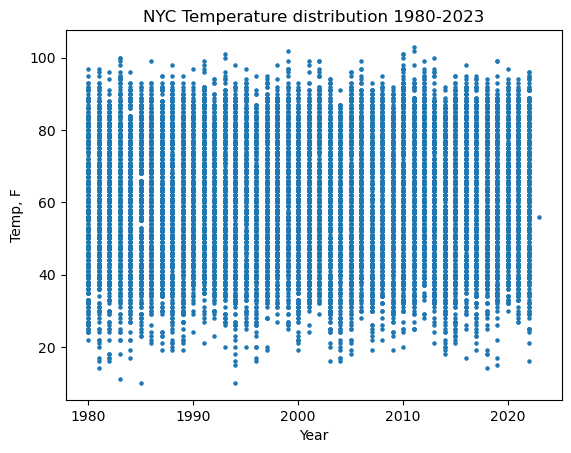

In [111]:
plt.scatter(NYC_updated.index.year, NYC_updated['TMAX'], s = 5)
plt.title("NYC Temperature distribution 1980-2023")
plt.xlabel('Year')
plt.ylabel('Temp, F')

Text(0, 0.5, 'Temp, F')

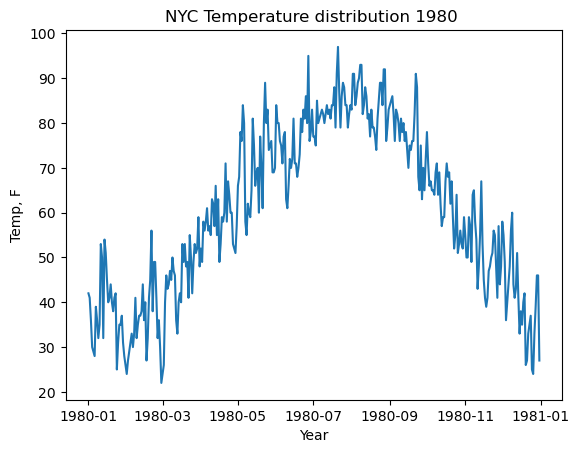

In [112]:
a = 0
plt.plot(NYC_updated.index[NYC_updated.index.year == NYC_updated.index.year[a]], 
         NYC_updated.loc[NYC_updated.index.year== NYC_updated.index.year[a], ['TMAX']])
plt.title(f"NYC Temperature distribution {NYC_updated.index.year[a]} " )
plt.xlabel('Year')
plt.ylabel('Temp, F')

In [113]:
#This is a function that selects a subset of the data, based on a start year and end year, 
#city must be entered as a string
def get_timeseries(city,start_year,end_year):
    if(city == "NYC"):
       last_year_data = NYC_updated[(NYC_updated.index.year>=start_year) 
                                  & (NYC_updated.index.year<=end_year)]
    else:
        print("Enter Valid city")
        
    return last_year_data

In [114]:
ts1 = get_timeseries('NYC', 1980, 2000)

In [115]:
ts1['TMAX']

DATE
1980-01-01    42
1980-01-02    41
1980-01-03    36
1980-01-04    30
1980-01-05    29
              ..
2000-12-27    33
2000-12-28    28
2000-12-29    32
2000-12-30    31
2000-12-31    30
Name: TMAX, Length: 7671, dtype: int64

In [116]:
# Here is a function that plots a feature over a specific time period, 
#feat and city must be entered as strings 
def plot_timeseries(city, start_year,end_year, feat):
    last_year_data = get_timeseries(city, start_year,end_year)
    plt.plot(last_year_data.index,last_year_data[feat])
    plt.title(f"{feat} from {start_year} to {end_year}")
    plt.xlabel('Date (Y/M/D)')
    plt.ylabel(feat)
    plt.xticks(rotation=45)


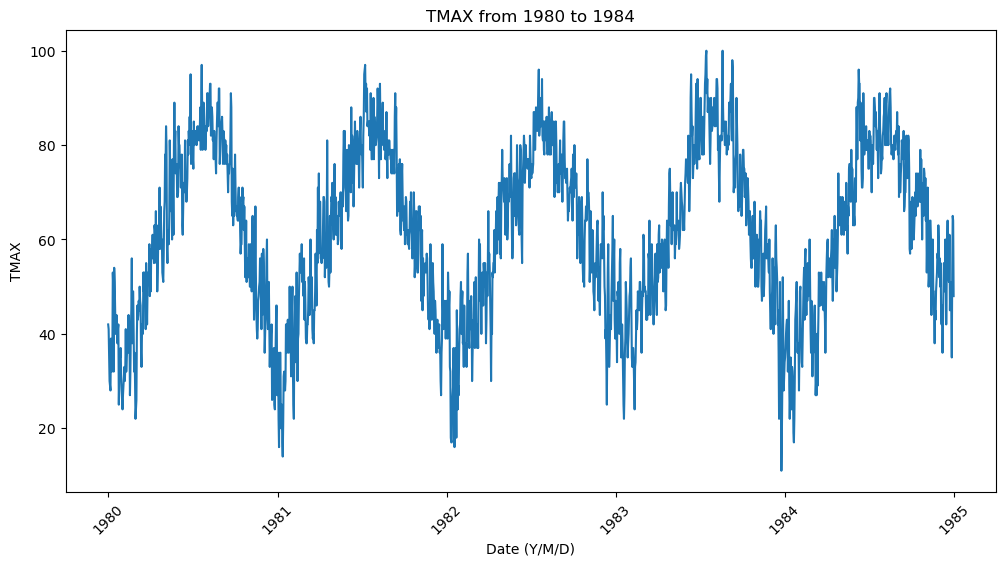

In [117]:
plt.figure(figsize=(12, 6))
plot_timeseries("NYC", 1980, 1984, "TMAX")

In [118]:
from seaborn import heatmap
import seaborn as sns

<Axes: >

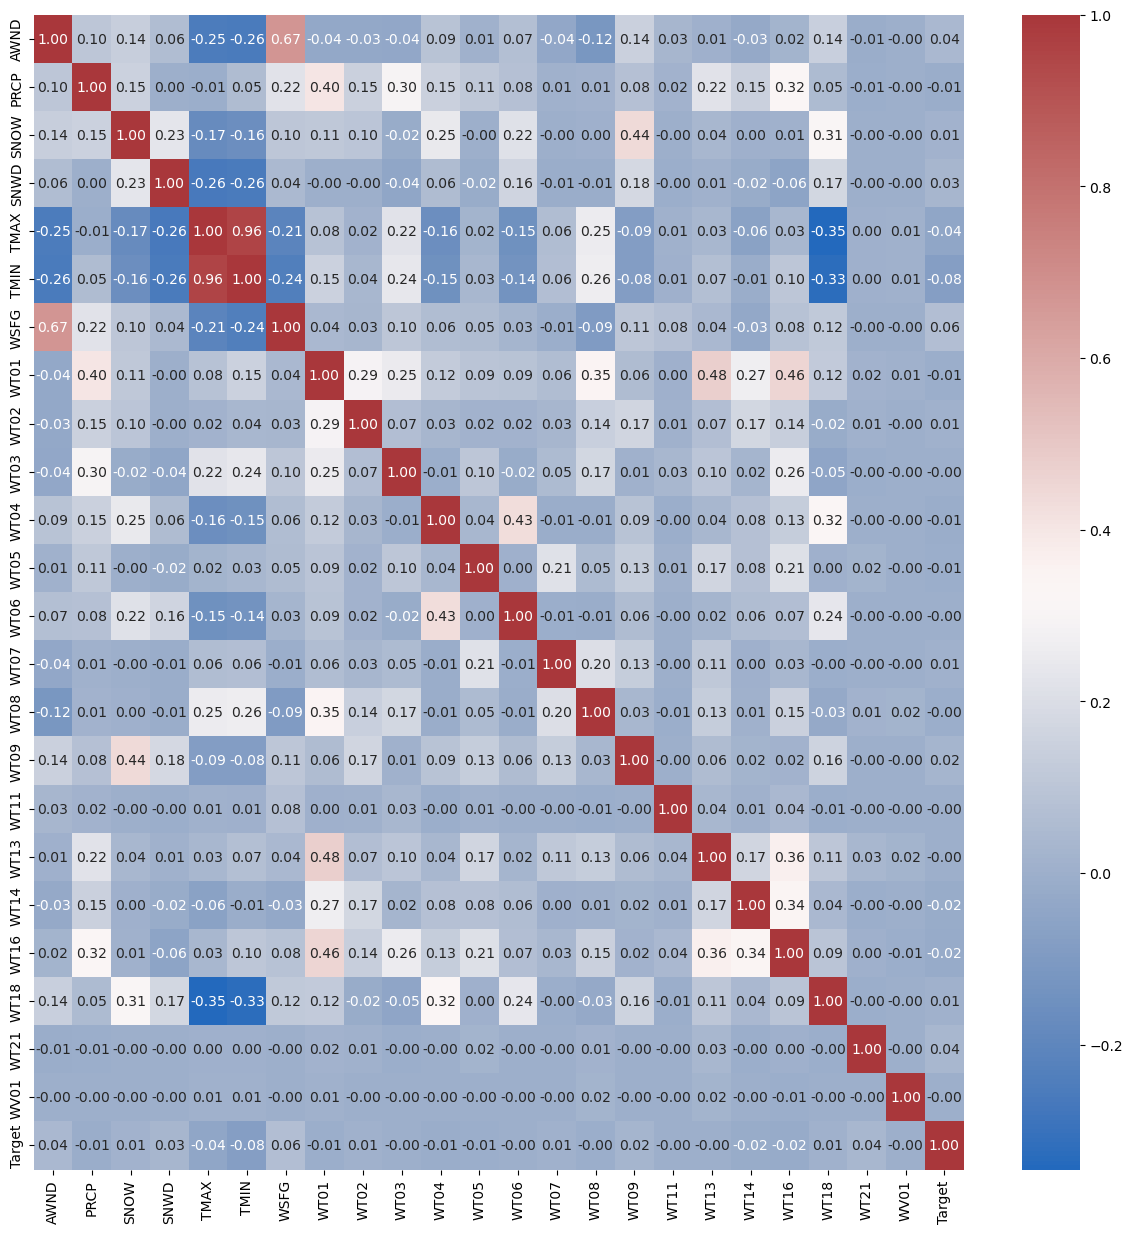

In [119]:
plt.figure(figsize=(15,15))
heatmap(NYC_updated.iloc[:,  2:].corr(),  annot=True, cmap = 'vlag', fmt=".2f")

In [120]:
NYC_updated['TMAX']

DATE
1980-01-01    42
1980-01-02    41
1980-01-03    36
1980-01-04    30
1980-01-05    29
              ..
2022-12-28    45
2022-12-29    46
2022-12-30    51
2022-12-31    51
2023-01-01    56
Name: TMAX, Length: 15707, dtype: int64

In [121]:
# mean temperature
average_tmax = NYC_updated['TMAX'].mean()
print("Average Temperature MAX:", average_tmax)
average_tmin = NYC_updated['TMIN'].mean()
print("Average Temperature MIN:", average_tmin)

max_temperature = NYC_updated['TMAX'].max()
min_temperature = NYC_updated['TMIN'].min()

print("Highest Temperature:", max_temperature)
print("Lowest Temperature:", min_temperature)

Average Temperature MAX: 61.998854014133826
Average Temperature MIN: 47.63684981218565
Highest Temperature: 103
Lowest Temperature: -2


### STL Decomposition Anomaly detection

The aim of this project is to be able to predict extreme weather events, not just regular weather. To do this we must first identify days with extreme weather. To do this I will use the STL(Season-Trend Loess) decomposition method. This involves taking cyclical time series data, and seperating it into base components: Seasonal,  overall Trend,  and Residuals(Data = Seasonal(S) + Trend(T)+ Residuals(R)). Residuals represent data that cannot be accounted for by either the seasonal component or the trend component( R = D - S -T). We use the residuals for detecting anomalies in the data, we will set a threshold or Mean +- 3 STD, any residual that is not included in that window is considered an anomaly.

In [122]:
import statsmodels.api as sm

import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL # uses LOESS

In [123]:
stl_train = get_timeseries('NYC', 1980, 2023)
stl_train= stl_train['TMAX']

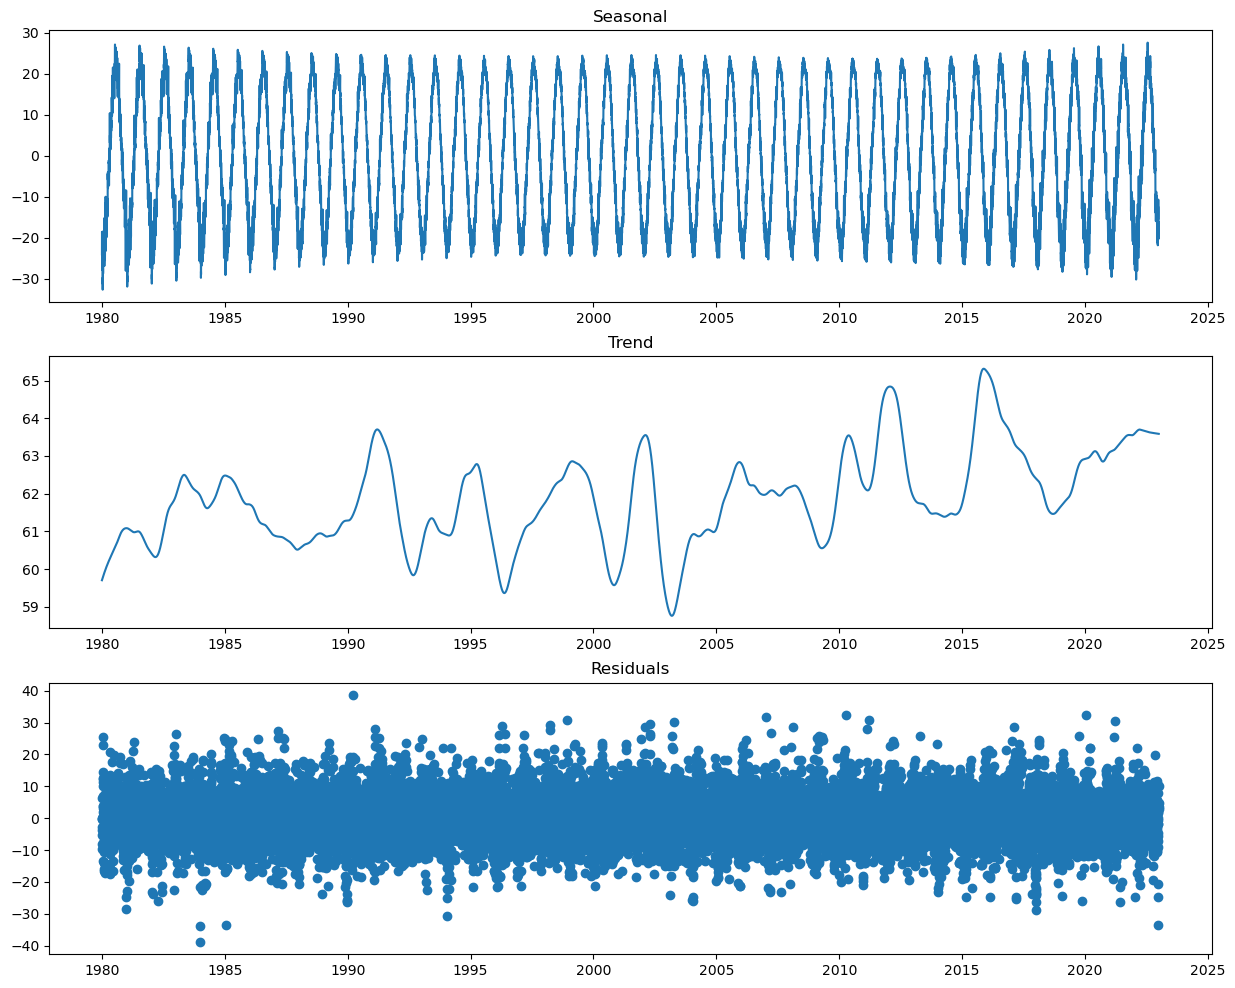

In [124]:
#Period is 1 year, that is the cycle of weather
stl = STL(stl_train, period = 365, seasonal = 35, robust = True)
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid
cleaned_data = seasonal + trend

plt.figure(figsize = (15, 12))

plt.subplot(3,1,1)
plt.plot(seasonal)
plt.title('Seasonal')

plt.subplot(3,1,2)
plt.plot(trend)
plt.title('Trend')

plt.subplot(3,1,3)
plt.scatter(resid.index, resid)
plt.title('Residuals')

plt.show()

In [125]:
#the residuals represent the remaining variability or noise in the time series after removing the estimated
#trend and seasonal components. The residual component is the part of the data that the decomposition algorithm 
#couldn't capture using the specified trend and seasonal components.

res_mean = resid.mean()
resid_std = resid.std()

#We can Identify anomalies(i.e. extreme weather) as residuals outside of 3 standard deviations of the mean of the residuals
#(or outside of 99.7% of the data
lower_bound = res_mean - 3*resid_std
upper_bound = res_mean + 3*resid_std


In [5]:
from scipy.stats import norm

#We can see from plotting the residuals, that they are normally distributed, 
#so +-3 Std from the mean will encompass 99.7% of the data


# Calculate mean and standard deviation of the data
mu, sigma = res_mean, resid_std

# Generate data points for x-axis
x = np.linspace(mu - 3*sigma, mu + 3*sigma, len(resid))

# Compute the PDF values for the normal distribution
pdf_values = norm.pdf(x, mu, sigma)

# Plot the theoretical normal distribution
plt.plot(x, pdf_values, label='Normal Distribution', color ='red')
plt.hist(resid,bins='auto', density=True, alpha=0.7, color='blue')

plt.vlines([lower_bound, upper_bound], ymin=0, ymax=norm.pdf(mu, mu, sigma), colors='red', linestyles='--', label='3 STD Away')

# Add labels and title
plt.xlabel('Residual values')
plt.ylabel('Probability Density')
plt.title('Normal Distribution of the Residuals')

# Show the plot
plt.legend()
plt.show()



NameError: name 'res_mean' is not defined

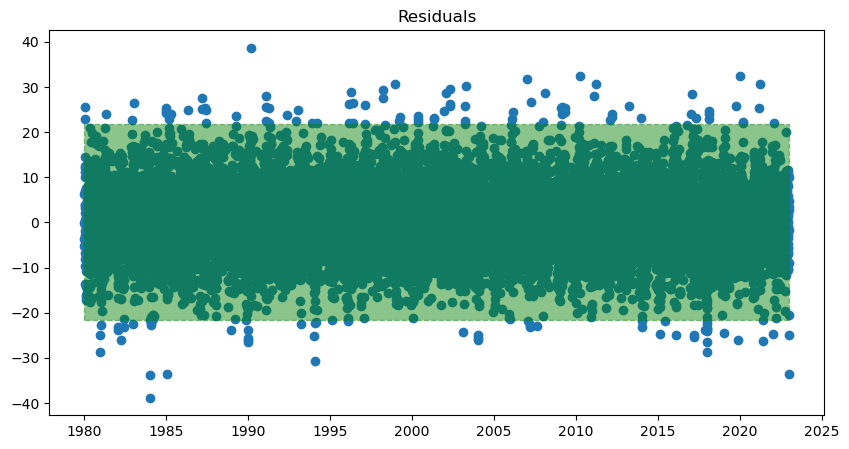

In [127]:
plt.figure(figsize = (10, 5))
plt.scatter(resid.index, resid)
plt.title('Residuals')
plt.fill_between([min(resid.index), max(resid.index)], upper_bound, lower_bound, color ='g', alpha= 0.45,linestyle='--' )

In [128]:
anomalies = NYC_updated[(resid < lower_bound) | (resid > upper_bound)]
len(anomalies)

143

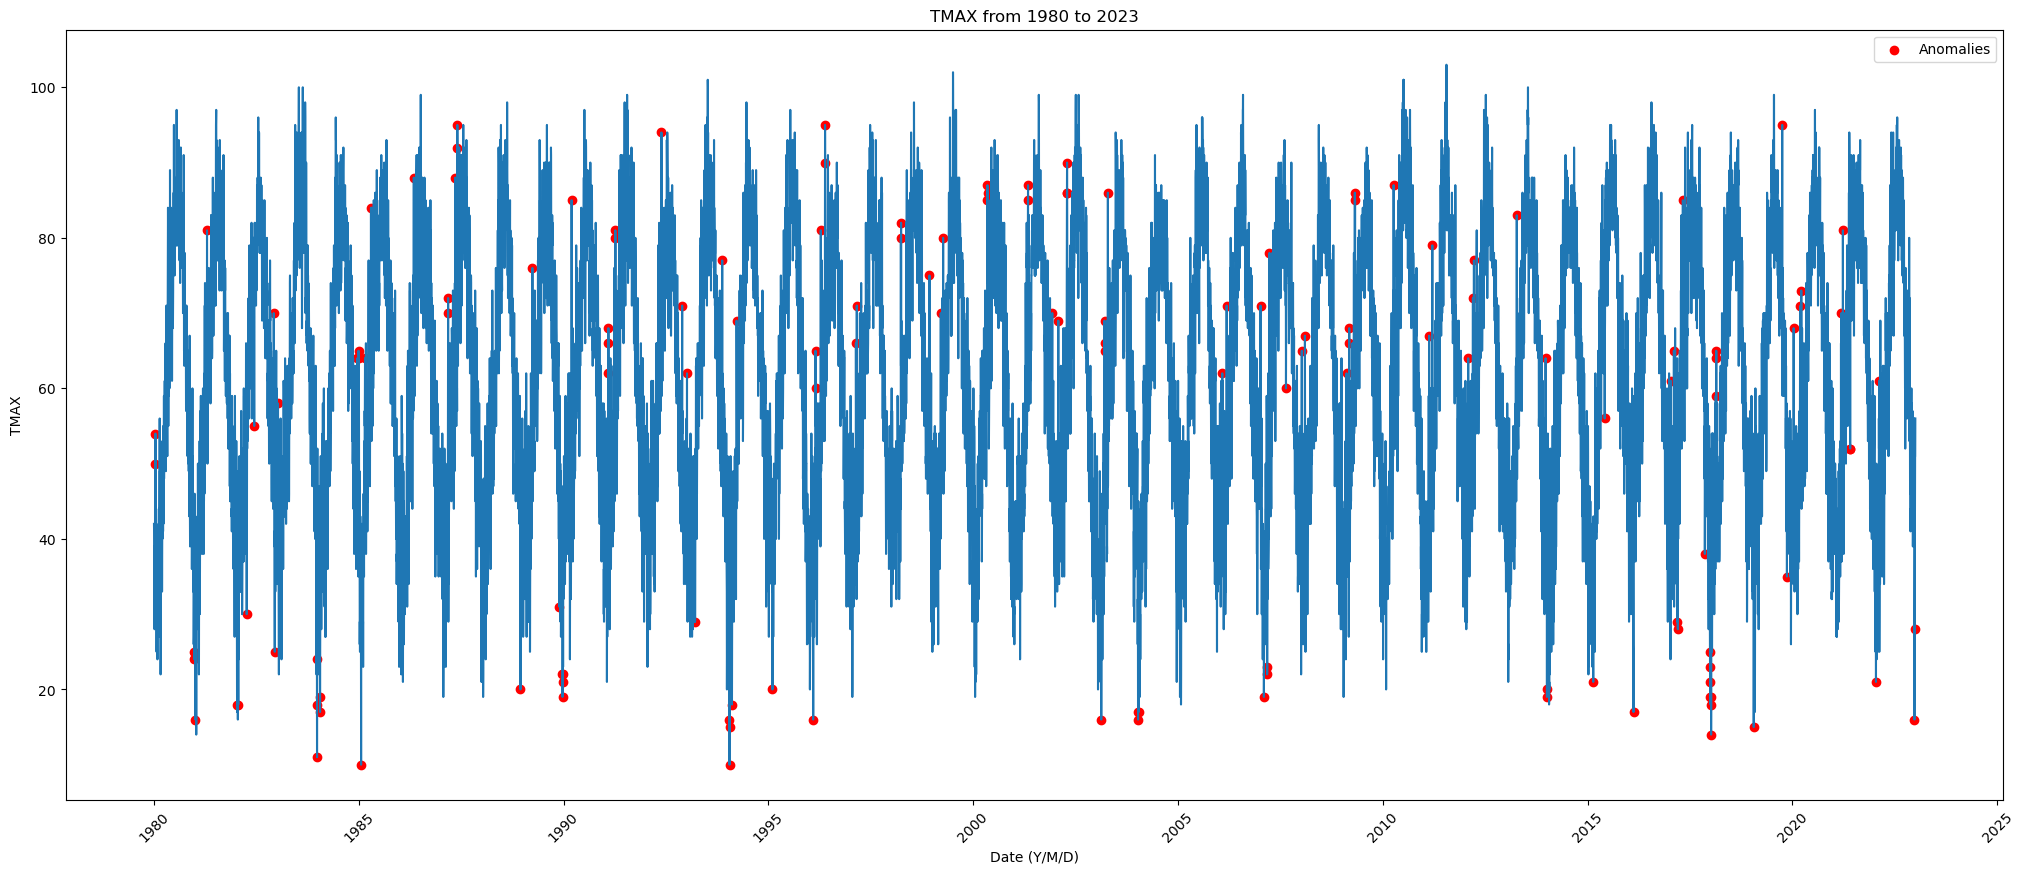

In [129]:
plt.figure(figsize=(25, 10))

plot_timeseries("NYC", 1980, 2023, "TMAX")
plt.scatter(anomalies.index, anomalies['TMAX'], color ='red', label = "Anomalies")
plt.legend()

In [130]:
#Here we can see how many anomalies there are each year
anomalies.index.year.value_counts().sort_index()

DATE
1980     4
1981     2
1982     6
1983     4
1984     5
1985     3
1986     1
1987     5
1988     1
1989     6
1990     1
1991     5
1992     2
1993     3
1994     5
1995     1
1996     6
1997     2
1998     3
1999     2
2000     3
2001     3
2002     4
2003     5
2004     3
2006     2
2007     6
2008     2
2009     5
2010     1
2011     2
2012     3
2013     2
2014     2
2015     2
2016     1
2017    10
2018     6
2019     3
2020     3
2021     4
2022     4
Name: count, dtype: int64

#### Now that we have a list of the Anomalies

This is what we will call "Extreme Weather", we can set that as a target vector. The vector will include a 0 on days that are not an anomaly and 1 are days that are.

In [131]:
#This creates a new column, with all 0 values
NYC_updated["Target"] = 0

#This updates the column, placing a 1 at all the anomaly indices
NYC_updated.loc[anomalies.index, 'Target'] = 1

### Lag Features

Now we have a dataframe with a target vector. I want the model to predictive, so I need to create a lag so that the model is predictive.

 The problem with  a single lag  is that it only includes one day, I think its important that the model looks at multiple  past days of information .

In [132]:
Lag_set1 = NYC_updated.iloc[:, 2:]

feat_names_to_lag = list(Lag_set1.columns)
feat_names_to_lag.remove('Target')
len(feat_names_to_lag)

23

In [133]:
for i in range(1, 11):
    for col in feat_names_to_lag:
        Lag_set1[f'{col}_lag_{i}'] = Lag_set1[col].shift(i)

/var/folders/nw/hmlqr79n3czgrmldxwy475lr0000gn/T/ipykernel_63196/1573131271.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Lag_set1[f'{col}_lag_{i}'] = Lag_set1[col].shift(i)
/var/folders/nw/hmlqr79n3czgrmldxwy475lr0000gn/T/ipykernel_63196/1573131271.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Lag_set1[f'{col}_lag_{i}'] = Lag_set1[col].shift(i)
/var/folders/nw/hmlqr79n3czgrmldxwy475lr0000gn/T/ipykernel_63196/1573131271.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [134]:
Lag_set1

,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WSFG,WT01,WT02,WT03,...,WT07_lag_10,WT08_lag_10,WT09_lag_10,WT11_lag_10,WT13_lag_10,WT14_lag_10,WT16_lag_10,WT18_lag_10,WT21_lag_10,WV01_lag_10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-01,11.237327,0.00,0.0,0.0,42,26,11.4,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,11.237327,0.00,0.0,0.0,41,31,32.2,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,11.237327,0.00,0.0,0.0,36,28,20.8,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,11.237327,0.00,0.0,0.0,30,20,21.9,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,11.237327,0.09,3.0,2.0,29,25,36.7,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,8.500000,0.00,0.0,0.0,45,27,19.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-29,7.160000,0.00,0.0,0.0,46,32,18.1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-30,6.260000,0.00,0.0,0.0,51,34,15.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we have a dataset, Lag_set1

This set has the same amount of samples, 15707, but many more features, 253, and 1 target column.
The 253 features are made up of 11 versions of the same 23 features. each copy has a lag 1 greater than the previous, up to a max of 10 days. I did this so that the model would be predictive, looking at data from 10 datas to predict a weather anomaly. I'm going to remove the data with a lag smaller than 4, this way the model is predicting 4 days in advance.

In [135]:
#here we drop the first 10 rows, which have null values thanks to our lagging 
Lag_set1 = Lag_set1.dropna() 
y_raw = Lag_set1['Target' ]

Lag_set1 = Lag_set1.iloc[:, 93:] 
# this set removed the current days data + the 3 days prior, so the dataset only includes data from 5-10 days prior
Lag_set1.head()

,AWND_lag_4,PRCP_lag_4,SNOW_lag_4,SNWD_lag_4,TMAX_lag_4,TMIN_lag_4,WSFG_lag_4,WT01_lag_4,WT02_lag_4,WT03_lag_4,...,WT07_lag_10,WT08_lag_10,WT09_lag_10,WT11_lag_10,WT13_lag_10,WT14_lag_10,WT16_lag_10,WT18_lag_10,WT21_lag_10,WV01_lag_10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-11,11.237327,0.00,0.0,0.0,39.0,28.0,39.1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-12,11.237327,0.00,0.0,0.0,36.0,31.0,31.1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-13,11.237327,0.00,0.0,0.0,32.0,27.0,20.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1980-01-14,11.237327,0.00,0.0,0.0,35.0,23.0,21.9,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1980-01-15,11.237327,0.45,0.0,0.0,53.0,35.0,52.8,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [136]:
X_raw = Lag_set1
print(len(X_raw))

15697


In [137]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.3, random_state=1, stratify=None)

In [138]:
len(X_train.columns)

161

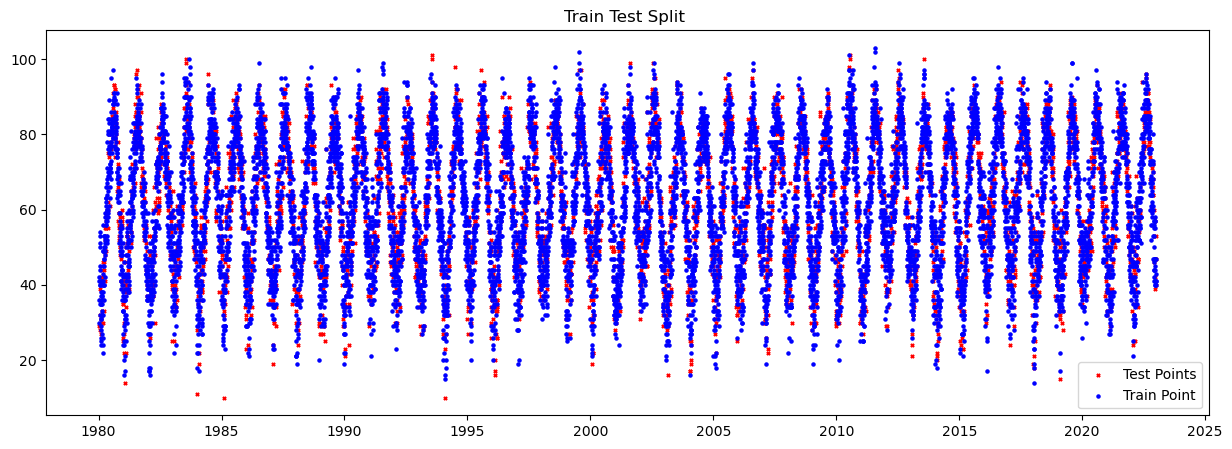

In [139]:
plt.figure(figsize=(15, 5))
plt.scatter(X_test.index, X_test['TMAX_lag_10'], color = 'red', s = 5, marker = 'x', label= "Test Points", )
plt.scatter(X_train.index, X_train['TMAX_lag_10'], color = 'blue', s = 5, label = "Train Point")

plt.title("Train Test Split ")
plt.legend()

## Creating the models 

Now that we have the Feature matrix, and target vector, as well as a split train and test set of data.

I also need to note that the classes(Normal and Anomaly) are extremely unbalanced. To handle this I will be using the class_weight parameter in each model, and setting it to 'balanced'


## Decision Trees

In [140]:
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score

In [141]:
feature_names = X_train.columns
class_names = ['Normal', 'Anomalies']

In [142]:
#Testing Gini Trees

md = [1, 3, 6, 9, 12, 15, 18] # Max tree depths
gini_trees = [] #list of trees 
gini_acc =[] #list of accuracies
gini_acc_tr =[] #list of accuracies

for i in range(len(md)):
    #We have the class_weight parameter set to 'balanced' to account for the size differnece in anomalies and normal days
    gini_instance = DecisionTreeClassifier(criterion = "gini", random_state = 50,
                               max_depth=md[i], min_samples_leaf=5, class_weight = 'balanced')

    # Train the decision tree on the training data
    gini_instance.fit(X_train, y_train)

    # Add the trained decision tree to the list
    gini_trees.append(gini_instance)



for j, tree_instance in enumerate(gini_trees):
    predictions = tree_instance.predict(X_test)
    pred_tr = tree_instance.predict(X_train)
    accuracy = accuracy_score(y_test, predictions)
    tr_accuracy = accuracy_score(y_train, pred_tr)
    gini_acc_tr.append(tr_accuracy)
    gini_acc.append(accuracy)
    print(f"Gini {j+1} Tree Accuracy: {accuracy}")


Gini 1 Tree Accuracy: 0.4407643312101911
Gini 2 Tree Accuracy: 0.5002123142250531
Gini 3 Tree Accuracy: 0.6360934182590233
Gini 4 Tree Accuracy: 0.7116772823779193
Gini 5 Tree Accuracy: 0.7906581740976646
Gini 6 Tree Accuracy: 0.8225053078556264
Gini 7 Tree Accuracy: 0.8337579617834395


In [143]:
#Testing Entropy Trees


entropy_trees = [] #list of trees 
entropy_acc =[] #list of accuracies
entropy_acc_tr =[] #list of accuracies


for i in range(len(md)):
    #We have the class_weight parameter set to 'balanced' to account for the size differnece in anomalies and normal days
    entropy_tree = DecisionTreeClassifier(criterion = "entropy", random_state = 50,
                               max_depth=md[i], min_samples_leaf=5, class_weight = 'balanced')

    # Train the decision tree on the training data
    entropy_tree.fit(X_train, y_train)

    # Add the trained decision tree to the list
    entropy_trees.append(entropy_tree)



for j, tree_instance in enumerate(entropy_trees):
    
    predictions = tree_instance.predict(X_test)
    pred_tr= tree_instance.predict(X_train)
    accuracy = accuracy_score(y_test, predictions)
    tr_accuracy = accuracy_score(y_train, pred_tr)
    entropy_acc.append(accuracy)
    entropy_acc_tr.append(tr_accuracy)
    print(f"Entropy Tree {j + 1} Accuracy: {accuracy}")


Entropy Tree 1 Accuracy: 0.4407643312101911
Entropy Tree 2 Accuracy: 0.5144373673036093
Entropy Tree 3 Accuracy: 0.6331210191082802
Entropy Tree 4 Accuracy: 0.6895966029723991
Entropy Tree 5 Accuracy: 0.7562632696390659
Entropy Tree 6 Accuracy: 0.8208067940552017
Entropy Tree 7 Accuracy: 0.8853503184713376


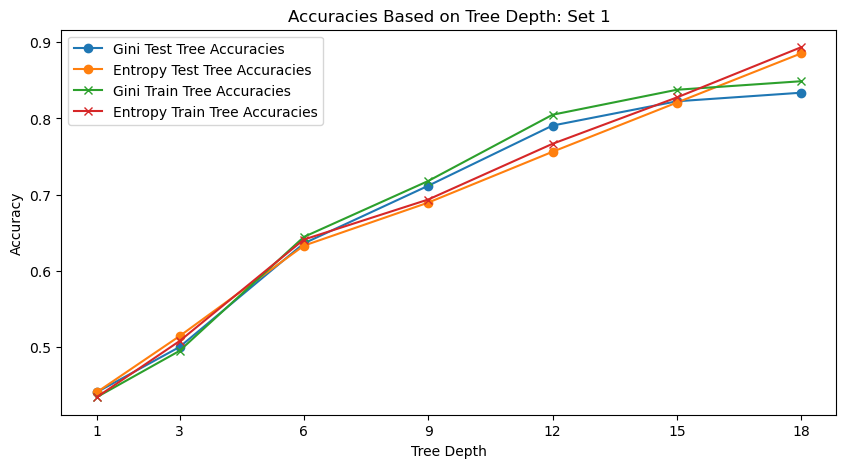

In [144]:
plt.figure(figsize = [10,5])
plt.plot(md, gini_acc, label = 'Gini Test Tree Accuracies', marker = 'o')
plt.plot(md, entropy_acc, label = 'Entropy Test Tree Accuracies', marker = 'o')

plt.plot(md, gini_acc_tr, label = 'Gini Train Tree Accuracies', marker = 'x')
plt.plot(md, entropy_acc_tr, label = 'Entropy Train Tree Accuracies', marker = 'x')

plt.xticks(md)
plt.xlabel('Tree Depth')
plt.ylabel("Accuracy")

plt.legend()
plt.title('Accuracies Based on Tree Depth: Set 1')
plt.show()


### Notes
From the plots above we can see that accuracies of the decision tree classifiers aren't bad, especially as tree depth increases. But the most accurate tree(Entropy measure, 18 depth) only has an accuracy of 92%. We can do better than that 

In [145]:
# Feature Importance

feature_importance = gini_trees[-1].feature_importances_
arr = sorted(feature_importance, reverse = True)

# Get indices of top N features
top_n_indices = np.argsort(feature_importance)[::-1][:10]

# Select the top N feature names
top_n_feature_names = [feature_names[i] for i in top_n_indices]

# Print or use the top N feature names
print("Top 10 features:", top_n_feature_names)

Top 10 features: ['TMIN_lag_10', 'TMAX_lag_7', 'AWND_lag_10', 'WSFG_lag_8', 'TMAX_lag_6', 'PRCP_lag_5', 'TMAX_lag_5', 'TMAX_lag_9', 'TMIN_lag_7', 'PRCP_lag_10']


### Notes
The decision tree is not very accurate. It should worry us that the 3 most important features in this model have some of the most lag, or are data from furthest away. 

#### Plot of Decision Tree

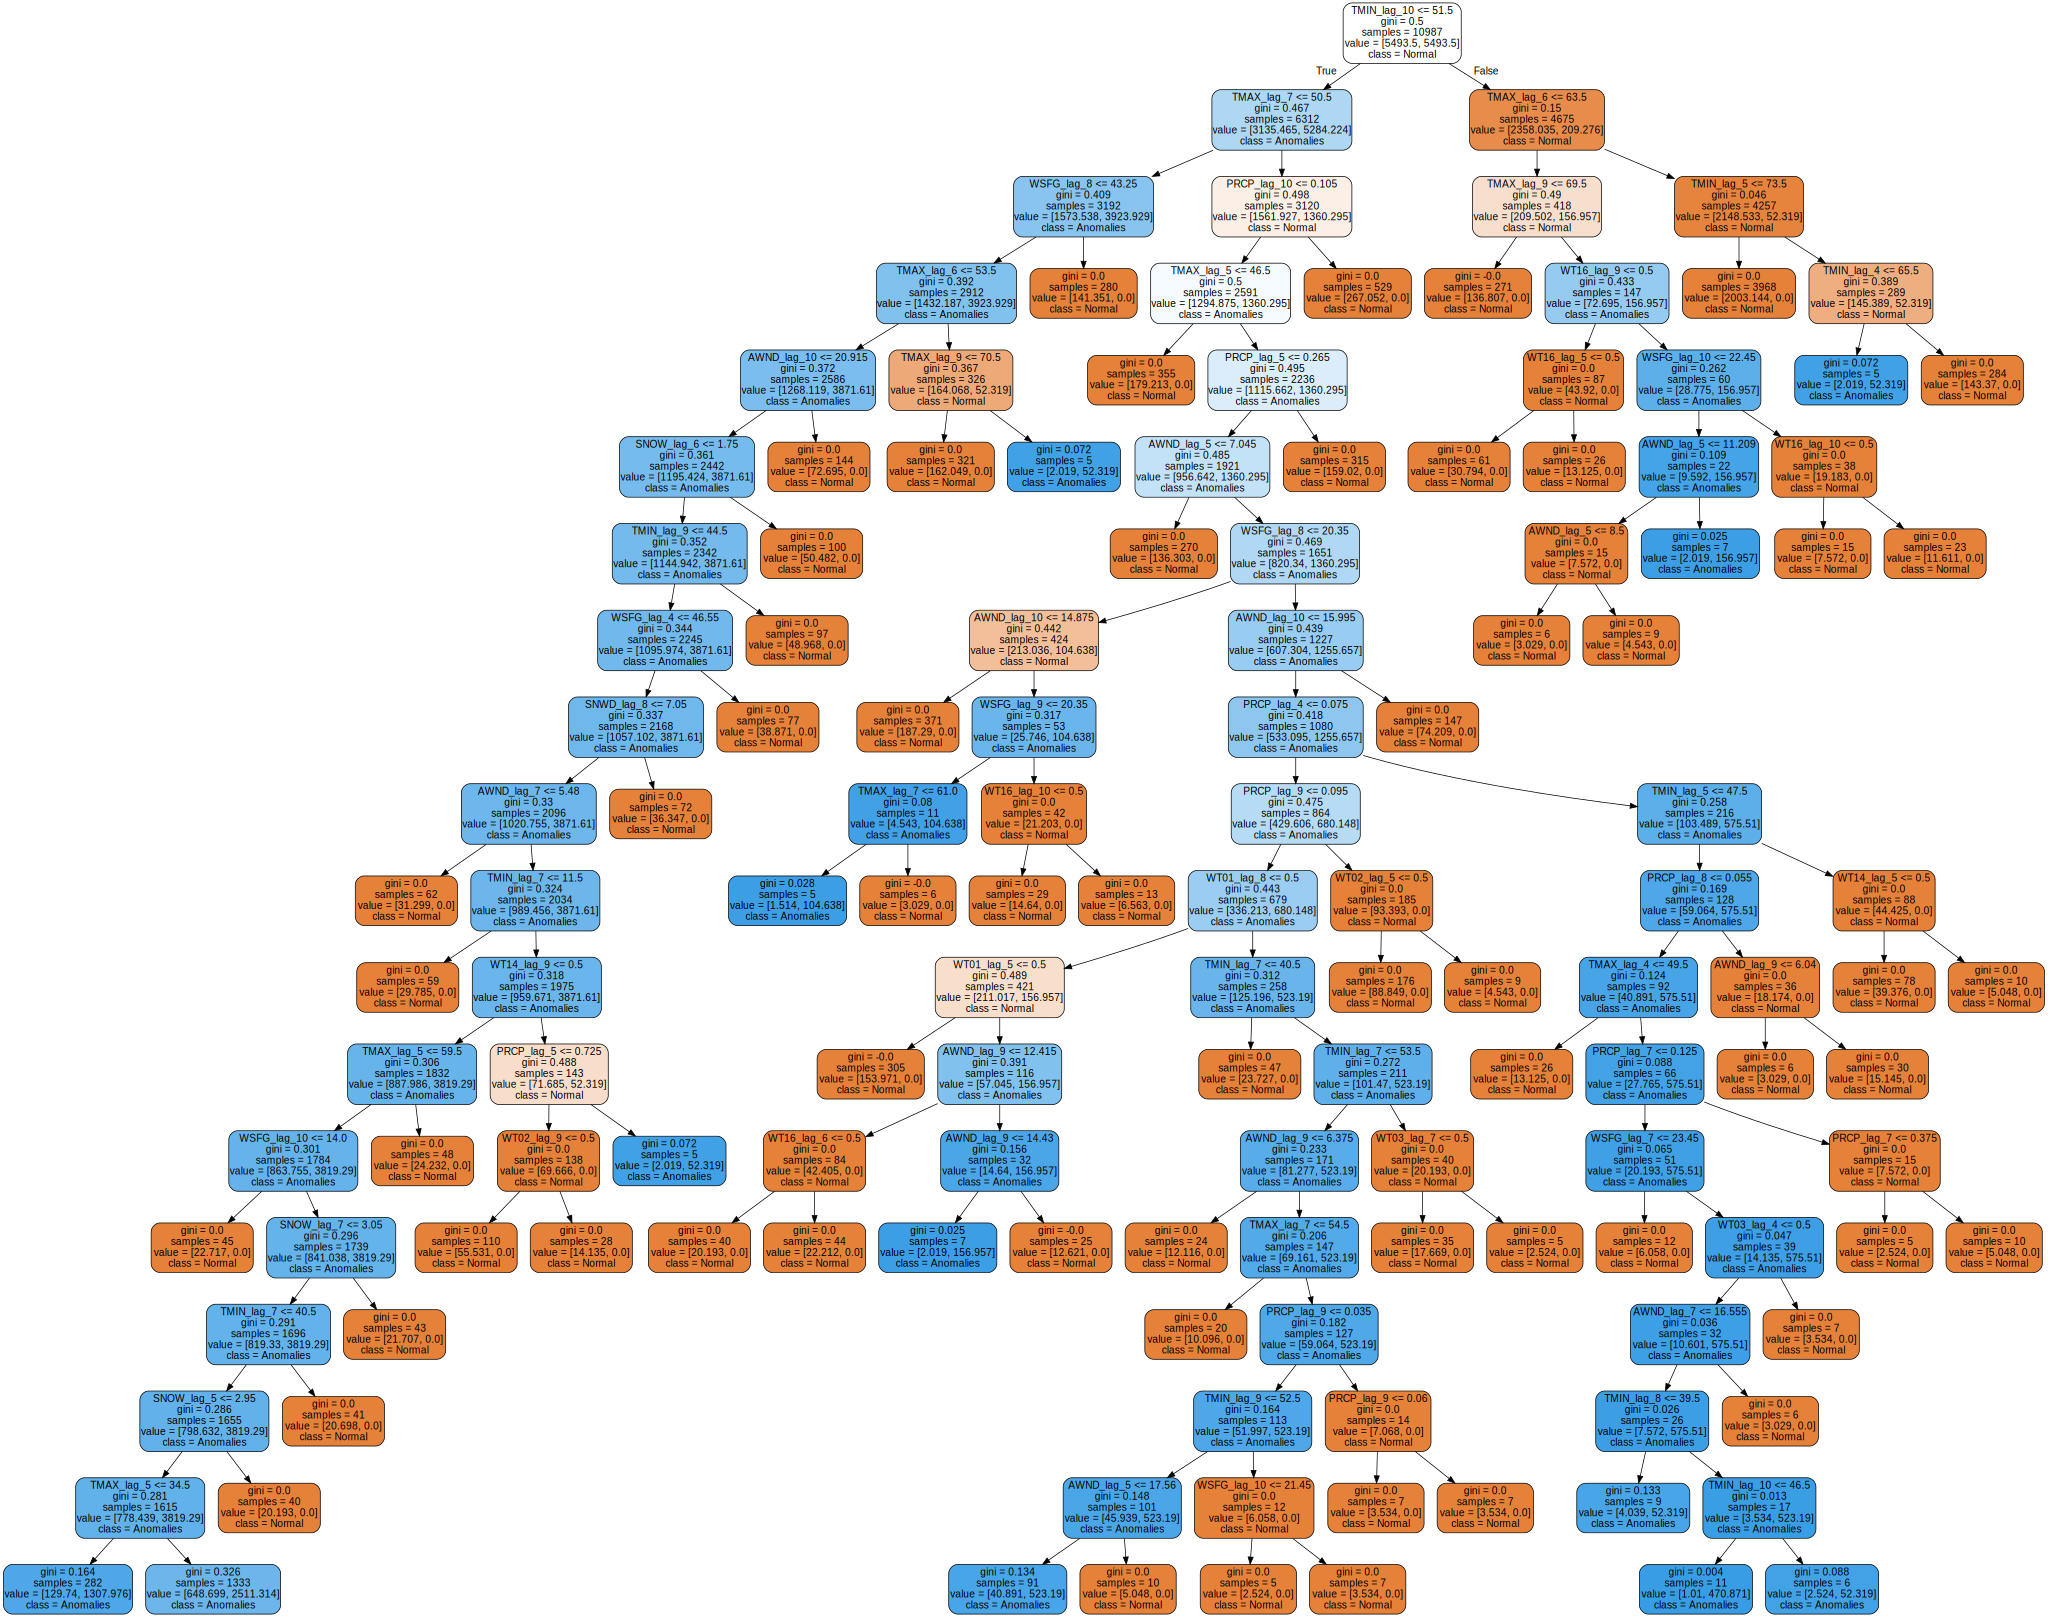

In [146]:
# Visualizing the Gini Tree with depth 3
graph_data = tree.export_graphviz(gini_trees[-1], out_file=None, filled=True, rounded=True,
                                feature_names=feature_names,  
                                class_names=class_names)
graph = graphviz.Source(graph_data)  
graph


## Random Forests


In [60]:
from sklearn.ensemble import RandomForestClassifier

Gini Test Accuracy: 0.8868365180467092
Gini Train Accuracy: 0.8987894784745608

Entropy Test Accuracy: 0.8713375796178344
Entropy Train Accuracy: 0.8834076636024393


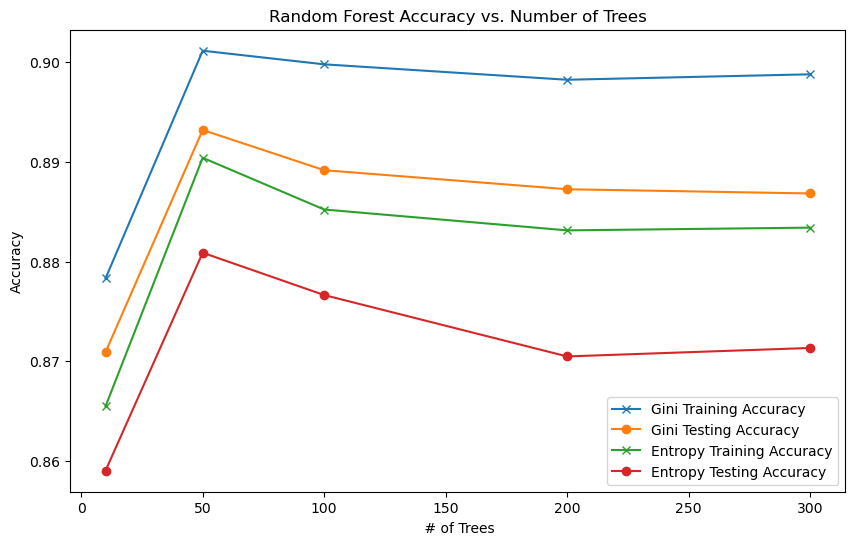

In [61]:
n_trees_values = [10, 50, 100, 200, 300]

# Lists to store accuracy values
gini_train_accuracies = []
gini_test_accuracies = []

entropy_train_accuracies = []
entropy_test_accuracies = []


# Iterate over different number of trees
for n_trees in n_trees_values:
    # Create a Random Forest classifier with the current number of trees
    gini_rf = RandomForestClassifier(n_estimators = n_trees, criterion = 'gini',min_samples_leaf=3, max_depth=7, random_state=0, class_weight = 'balanced')
    gini_rf.fit(X_train, y_train)

    
    entropy_rf = RandomForestClassifier(n_estimators = n_trees, criterion = 'entropy', min_samples_leaf=3, max_depth=7, random_state=0, class_weight = 'balanced')
    entropy_rf.fit(X_train, y_train)
   
    #GINI TREES
    # Make predictions on the training set
    gini_train_predictions = gini_rf.predict(X_train)
    gini_train_accuracy = accuracy_score(y_train, gini_train_predictions)
    gini_train_accuracies.append(gini_train_accuracy)
    # Make predictions on the test set
    gini_test_predictions = gini_rf.predict(X_test)
    gini_test_accuracy = accuracy_score(y_test, gini_test_predictions)
    gini_test_accuracies.append(gini_test_accuracy)
    
    #ENTROPY TREES
    # Make predictions on the training set
    entropy_train_predictions = entropy_rf.predict(X_train)
    entropy_train_accuracy = accuracy_score(y_train, entropy_train_predictions)
    entropy_train_accuracies.append(entropy_train_accuracy)
    # Make predictions on the test set
    entropy_test_predictions = entropy_rf.predict(X_test)
    entropy_test_accuracy = accuracy_score(y_test, entropy_test_predictions)
    entropy_test_accuracies.append(entropy_test_accuracy)

    
    
    
    
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_trees_values, gini_train_accuracies, label='Gini Training Accuracy', marker='x')
plt.plot(n_trees_values, gini_test_accuracies, label='Gini Testing Accuracy', marker='o')

plt.plot(n_trees_values, entropy_train_accuracies, label='Entropy Training Accuracy', marker='x')
plt.plot(n_trees_values, entropy_test_accuracies, label='Entropy Testing Accuracy', marker='o')
plt.title('Random Forest Accuracy vs. Number of Trees')
plt.xlabel(" # of Trees")
plt.ylabel('Accuracy')
plt.legend()

print(f"Gini Test Accuracy: {gini_test_accuracies[-1]}")
print(f"Gini Train Accuracy: {gini_train_accuracies[-1]}")
print()
print(f"Entropy Test Accuracy: {entropy_test_accuracies[-1]}")
print(f"Entropy Train Accuracy: {entropy_train_accuracies[-1]}")

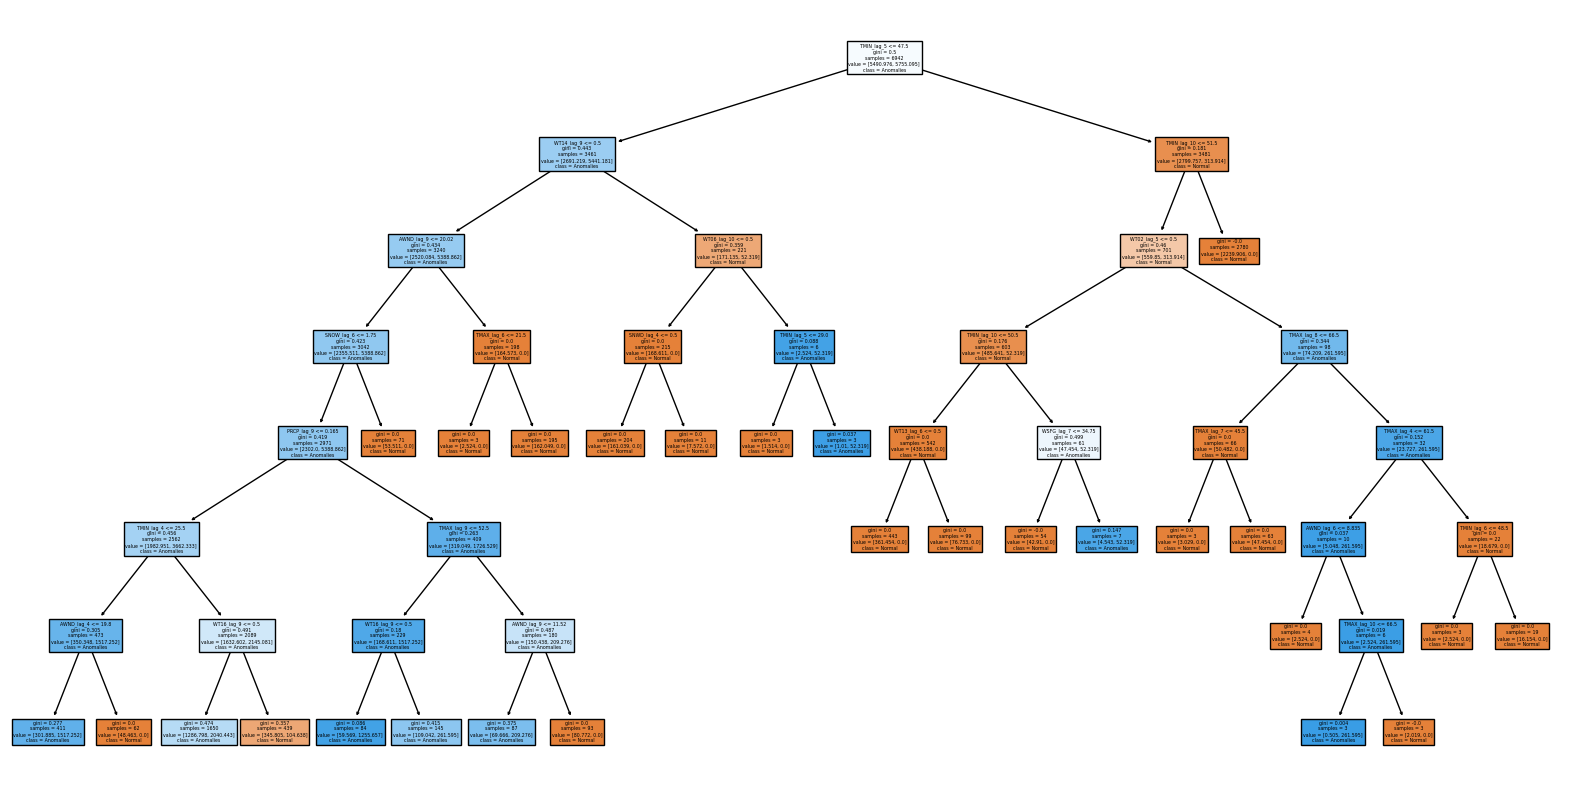

In [62]:
from sklearn.tree import plot_tree


gini_rf1 = RandomForestClassifier(n_estimators = 300, criterion = 'gini',min_samples_leaf=3, max_depth=7, random_state=0, class_weight = 'balanced')
gini_rf1.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(gini_rf1.estimators_[0], feature_names=list(feature_names), class_names=class_names, filled=True)
plt.show()

['TMIN_lag_4' 'TMAX_lag_8' 'TMAX_lag_6' 'TMAX_lag_4' 'TMAX_lag_7'
 'TMAX_lag_10' 'TMAX_lag_5' 'TMIN_lag_9' 'TMIN_lag_10' 'TMIN_lag_5']


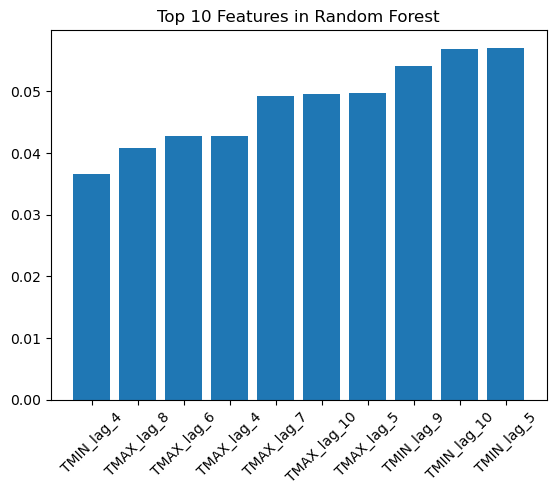

In [63]:
# Display feature importance
feature_importance = gini_rf1.feature_importances_

# Get the indices of the top N features
top_n_indices = np.argsort(feature_importance)[-10:]

# Get the names of the top N features
top_n_features = np.array(feature_names)[top_n_indices]

# Get the corresponding importance values
top_n_importance = feature_importance[top_n_indices]
print(top_n_features)
# Plot feature importance for the top N features
plt.bar(range(len(top_n_importance)), top_n_importance, tick_label=top_n_features)
plt.title('Top 10 Features in Random Forest')
plt.xticks(rotation = 45)
plt.show()

### Notes

The accuracy of the Random forest isn't that much better than of a single tree. It also seems to be prone to overfitting. I think this is because the Random Forest Model doesn't respond well the noisey data

## Adaboost

using the entropy_trees list and the gini_trees list

base estimator depths : 1, 3, 6, 9, 12, 15, 18

In [64]:
from sklearn.ensemble import AdaBoostClassifier

In [65]:
gini_ada = []
entropy_ada = []

ada_gini_acc = []
tr_ada_gini_acc = []

ada_entropy_acc= []
tr_ada_entropy_acc= []

for j, tree_instance in enumerate(entropy_trees):
    # Create adaboost classifer object
    abc_entropy = AdaBoostClassifier(estimator=entropy_trees[j])
    abc_entropy.fit(X_train, y_train)
    entropy_ada.append(abc_entropy)
    
    #predict
    tr_ada_entropy_pred = abc_entropy.predict(X_train)
    ada_entropy_pred = abc_entropy.predict(X_test)
    #accuracy score
    entropy_train_accuracy = accuracy_score(y_train, tr_ada_entropy_pred)
    tr_ada_entropy_acc.append(entropy_train_accuracy)
    
    entropy_test_accuracy = accuracy_score(y_test, ada_entropy_pred)
    ada_entropy_acc.append(entropy_test_accuracy)
    
    
for k, tree_instance in enumerate(gini_trees):
    # Create adaboost classifer object
    abc_gini = AdaBoostClassifier(estimator=gini_trees[k])
    abc_gini.fit(X_train, y_train)
    gini_ada.append(abc_gini)
    
    tr_ada_gini_pred = abc_gini.predict(X_train)
    ada_gini_pred = abc_gini.predict(X_test)
    
    gini_train_accuracy = accuracy_score(y_train, tr_ada_gini_pred)
    tr_ada_gini_acc.append(gini_train_accuracy)
    
    gini_test_accuracy = accuracy_score(y_test, ada_gini_pred)
    ada_gini_acc.append(gini_test_accuracy)

    

Gini Test Accuracy 0.991932059447983
Entropy Test Accuracy 0.991932059447983


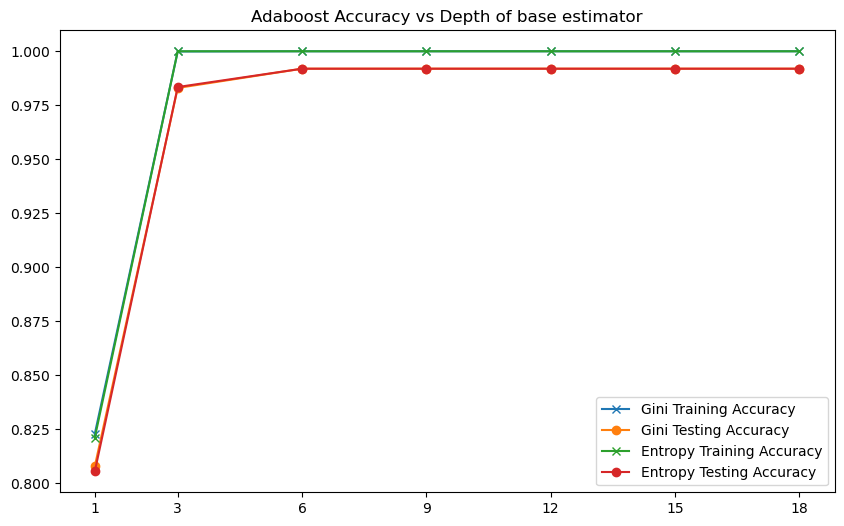

In [66]:
# Plot the results
print(f"Gini Test Accuracy {(max(ada_gini_acc))}")
print(f"Entropy Test Accuracy {max(ada_entropy_acc)}")     
      
plt.figure(figsize=(10, 6))
plt.plot(md, tr_ada_gini_acc, label='Gini Training Accuracy', marker='x')
plt.plot(md, ada_gini_acc, label='Gini Testing Accuracy', marker='o')

plt.plot(md, tr_ada_entropy_acc, label='Entropy Training Accuracy', marker='x')
plt.plot(md, ada_entropy_acc, label='Entropy Testing Accuracy', marker='o')
plt.title('Adaboost Accuracy vs Depth of base estimator')
plt.xticks(md)
plt.legend()
 

In [67]:
boosting_acc_gini = pd.DataFrame(
    {
        "Number of trees": range(1, 51)
    }
).set_index("Number of trees")
for k, ada_tree in enumerate(gini_ada):
    boosting_acc_gini[f' Gini {k}'] =[ accuracy_score(y_test, y_pred)
            for y_pred in ada_tree.staged_predict(X_test)]
    
boosting_acc_entropy = pd.DataFrame(
    {
        "Number of trees": range(1, 51)
    }
).set_index("Number of trees")
for k, ada_tree in enumerate(entropy_ada):
    boosting_acc_entropy[f' Entropy {k}'] =[ accuracy_score(y_test, y_pred)
            for y_pred in ada_tree.staged_predict(X_test)]


/Users/ianadler/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ianadler/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ianadler/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ianadler/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ianadler/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ianadler

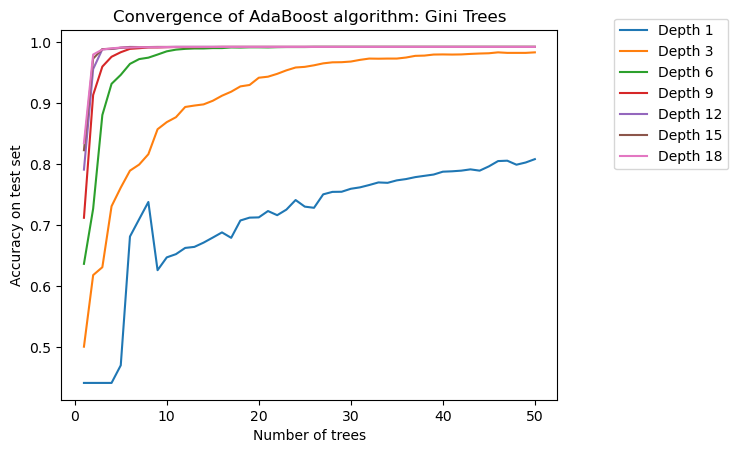

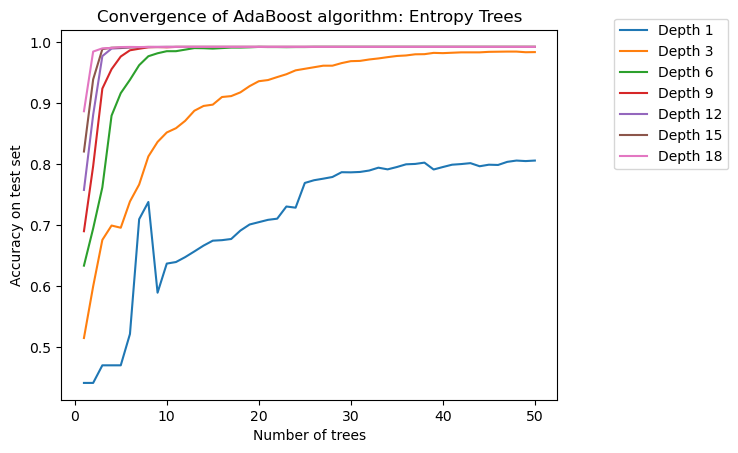

In [68]:
ax = boosting_acc_gini.plot()
ax.set_ylabel("Accuracy on test set")
ax.set_title("Convergence of AdaBoost algorithm: Gini Trees")

plt.legend(["Depth 1","Depth 3","Depth 6","Depth 9","Depth 12","Depth 15","Depth 18"], bbox_to_anchor=(1.1, 1.05))

ax2 = boosting_acc_entropy.plot()
ax2.set_ylabel("Accuracy on test set")
ax2.set_title("Convergence of AdaBoost algorithm: Entropy Trees")

plt.legend(["Depth 1","Depth 3","Depth 6","Depth 9","Depth 12","Depth 15","Depth 18"], bbox_to_anchor=(1.1, 1.05))


10 Most important features: Index(['WSFG_lag_8', 'TMAX_lag_9', 'TMAX_lag_7', 'TMIN_lag_4', 'WSFG_lag_9',
       'WSFG_lag_4', 'PRCP_lag_10', 'WSFG_lag_6', 'AWND_lag_10', 'TMAX_lag_6'],
      dtype='object')


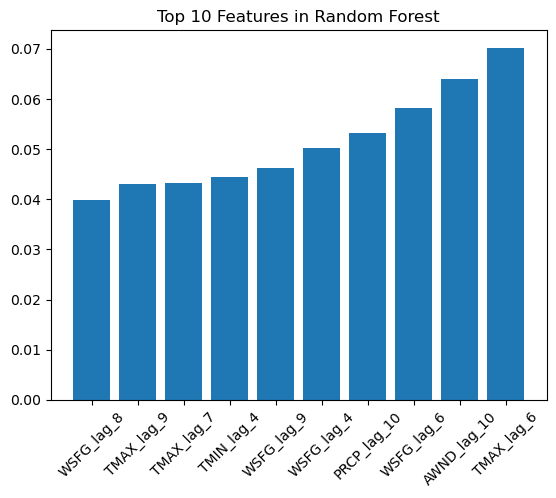

In [69]:
# Retrieve feature importances
feature_importances = gini_ada[-1].feature_importances_

# Get the indices of the top ten features
top_ten_indices = np.argsort(feature_importances)[-10:]



# Select only the top ten features from your original dataset
print(f"10 Most important features: {feature_names[top_ten_indices]}")
plt.bar(range(len(top_ten_indices)), feature_importances[top_ten_indices], tick_label=feature_names[top_ten_indices])
plt.title('Top 10 Features in Adaboost')
plt.xticks(rotation = 45)
plt.show()

### Notes

Although 100% accuracy on the test data is slightly concerning, the test accuracy is also extremely high. Also from the plots of accuracy vs number of trees  shows that the model is learning and increasing accuracy over time

## SVM Classifier

For the SVM we need to rescale the data, because SVM relies on the distance between points

In [70]:
from sklearn import svm

In [71]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


In [72]:
C = 10 # SVM regularization parameter


models = (
    svm.SVC(kernel="linear", C=C, class_weight = 'balanced'),
    svm.LinearSVC(C=C, max_iter=10000, dual="auto", class_weight = 'balanced'),
    svm.SVC(kernel="rbf", gamma=0.7, C=C, class_weight = 'balanced'),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C, class_weight = 'balanced'),
    svm.SVC(kernel='sigmoid',degree=3, gamma="auto", C=C, class_weight = 'balanced')
         )

models = (clf.fit(X_train_std, y_train) for clf in models)
# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
    "SVC with Sigmoid (degree 3) kernel"
)

y_train_prediction = [] # a 2d list of the predicted classifications of the different models
y_test_prediction = [] # a 2d list of the predicted classifications of the different models

for clf in models:
    
    y_train_prediction.append(clf.predict(X_train_std)) 
        
    y_test_prediction.append(clf.predict(X_test_std)) 


In [73]:

train_accuracy = [] # a 1d array, length equal to the number of models, of the accuracy of each model
for y_hat in y_train_prediction:
    train_accuracy.append(accuracy_score(y_train, y_hat))
    

test_accuracy = [] # a 1d array, length equal to the number of models, of the accuracy of each model
for y_hat in y_test_prediction:
    test_accuracy.append(accuracy_score(y_test, y_hat))


for i in range(len(train_accuracy)):
    print(titles[i], " train accuracy = ", train_accuracy[i])

print('\n')

for i in range(len(test_accuracy)):
    print(titles[i], " test accuracy = ", test_accuracy[i])


SVC with linear kernel  train accuracy =  0.7899335578410849
LinearSVC (linear kernel)  train accuracy =  0.7875671247838354
SVC with RBF kernel  train accuracy =  1.0
SVC with polynomial (degree 3) kernel  train accuracy =  0.9939929007008282
SVC with Sigmoid (degree 3) kernel  train accuracy =  0.65058705743151


SVC with linear kernel  test accuracy =  0.789171974522293
LinearSVC (linear kernel)  test accuracy =  0.7866242038216561
SVC with RBF kernel  test accuracy =  0.991932059447983
SVC with polynomial (degree 3) kernel  test accuracy =  0.9815286624203822
SVC with Sigmoid (degree 3) kernel  test accuracy =  0.6626326963906581


([0, 1, 2, 3, 4],
 [Text(0, 0, 'SVC with linear kernel'),
  Text(1, 0, 'LinearSVC (linear kernel)'),
  Text(2, 0, 'SVC with RBF kernel'),
  Text(3, 0, 'SVC with polynomial (degree 3) kernel'),
  Text(4, 0, 'SVC with Sigmoid (degree 3) kernel')])

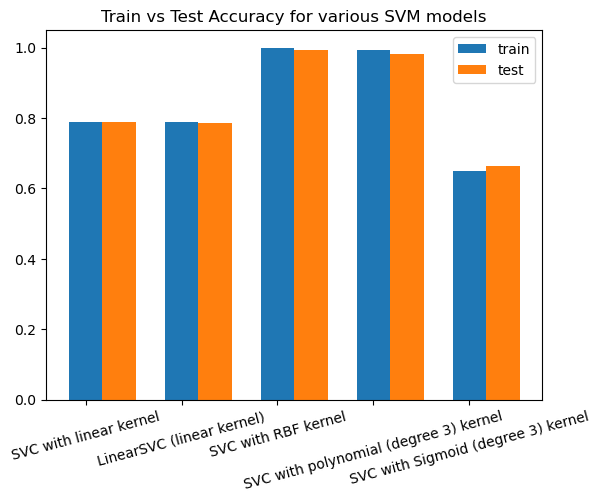

In [74]:
width = 0.35
x = range(len(titles))

plt.bar(titles, train_accuracy, width, label='train')
plt.bar([i + width for i in x], test_accuracy, width, label='test')
plt.legend()
plt.title('Train vs Test Accuracy for various SVM models')
plt.xticks(rotation=15)


### Notes

From the plots above we can see that some of the kernels are successful while others are not. Specifically RBF kernel and polynomial degree 3 have test accuracies > 0.98. The SVM model is effective for high dimensional data( AKA with a lot of features) and this set has 161 features. All the others perform rather poorly, probably because those kernels were not robust enough for the non-linear classes. Its also worth noting that this model took the longest to run.

### Plots

We can get an idea of the weights of different features 

In [75]:
test_SVM = svm.SVC(kernel="linear", C=C, class_weight = 'balanced')
test_SVM.fit(X_train_std, y_train)

SVC(C=10, class_weight='balanced', kernel='linear')

142 5 74
The parameters/features with the largest weights are: ['TMAX_lag_10', 'TMIN_lag_4', 'TMIN_lag_7', 'WT09_lag_8', 'SNWD_lag_5']


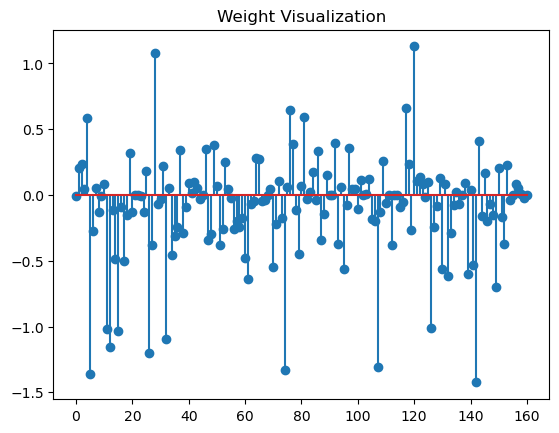

In [76]:
x_labels1 = X_train.columns
W = test_SVM.coef_
W=W.flatten()
plt.stem(W)
plt.title("Weight Visualization")
idx1=np.argsort(np.abs(W))[-1]
idx2=np.argsort(np.abs(W))[-2]
idx3=np.argsort(np.abs(W))[-3]
idx4=np.argsort(np.abs(W))[-4]
idx5=np.argsort(np.abs(W))[-5]
print(idx1, idx2, idx3)
heavy=[x_labels1[idx1], x_labels1[idx2],x_labels1[idx3], x_labels1[idx4],x_labels1[idx5]]
print("The parameters/features with the largest weights are: " + str(heavy))

## Accuracy

Lets plot the most accurate version of each model, which is:

SVM: RBF kernel; test_accuracy[2]

ADA: Gini and Entropy has the same accuracy; ada_entropy_acc[-1]

RandomForest: 100 Gini Trees; max(gini_test_accuracies)

Decision tree: Entropy tree depth 18; entropy_acc[-1]

([0, 1, 2, 3],
 [Text(0, 0, 'Decision Tree Entropy Depth 18'),
  Text(1, 0, '100 Gini Random Forest'),
  Text(2, 0, 'Adaboost'),
  Text(3, 0, ' SVM Classifier(RBF Kernel)')])

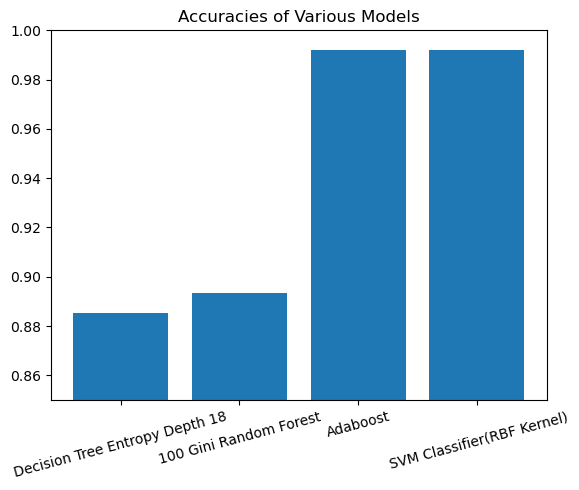

In [77]:


models_1 = ['Decision Tree Entropy Depth 18', "100 Gini Random Forest", 'Adaboost', ' SVM Classifier(RBF Kernel)']

acc_1 = [entropy_acc[-1], max(gini_test_accuracies) ,ada_entropy_acc[-1], max(test_accuracy)]
plt.ylim(0.85, 1)
plt.bar(models_1, acc_1)
plt.title("Accuracies of Various Models")
plt.xticks(rotation=15)


## Adding Alternate Features

Although the models performed well, I going to try the dataset with different features
Previously the dataset was made up a data lagged back 4 -10 days. This means the model classified the day as normal or anomaly using sampled from 4-10 days prior. This makes the model predictive. If it was collecting data live, it would be classifying the day 3 days ahead as normal or anomaly.

Some more features I can add:  
Rolling window: selecting a period and calculating some metric(mean, std, max...)  

Expanding window: this is like a cumulative window, as more sampled are read they are added to the window and the mean is calculated; We can do it per month and per day. So a month average is calculated for each month before the current one(the same month though, so all the past junes for example). Same for the daily expanding average  




We will start with the original data set, NYC_updated, create a lag of 5(so the model predicts 5 days in advance. Instead of lagging more, I will use a Rolling window and exapnding window

In [78]:
Lag_set2 = NYC_updated.iloc[:, 2:]

feat_names_lag = list(Lag_set2.columns)
feat_names_lag.remove('Target')


In [79]:
for col in feat_names_lag:
    Lag_set2[f'{col}_lag_5'] = Lag_set2[col].shift(5) #Lag the features by 5 days
    
Lag_set2 = Lag_set2.iloc[:, 23:] # here we get rid of the current features
Lag_set2.columns

Index(['Target', 'AWND_lag_5', 'PRCP_lag_5', 'SNOW_lag_5', 'SNWD_lag_5',
       'TMAX_lag_5', 'TMIN_lag_5', 'WSFG_lag_5', 'WT01_lag_5', 'WT02_lag_5',
       'WT03_lag_5', 'WT04_lag_5', 'WT05_lag_5', 'WT06_lag_5', 'WT07_lag_5',
       'WT08_lag_5', 'WT09_lag_5', 'WT11_lag_5', 'WT13_lag_5', 'WT14_lag_5',
       'WT16_lag_5', 'WT18_lag_5', 'WT21_lag_5', 'WV01_lag_5'],
      dtype='object')

In [80]:
def pct_diff(old, new):
    return (new - old) / (old).replace(0, 1)

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"
    weather[label] = weather[col].rolling(horizon).mean() #adds rolling average columns
    weather[f"{label}_pct"] = pct_diff(weather[label], weather[col]) # adds percent difference column(based on both rolling averages
    return weather
    
rolling_horizons = [3, 14]
cols = ['AWND_lag_5', 'PRCP_lag_5', 'SNOW_lag_5', 'SNWD_lag_5',
       'TMAX_lag_5', 'TMIN_lag_5', 'WSFG_lag_5'] 
# We only do the rolling stats for these features
#bc the others are only 1 or 0
for horizon in rolling_horizons:
    for col in cols:
        Lag_set2 = compute_rolling(Lag_set2, horizon, col)
#Now we have a dataset with rolling averages of 3 and 14 days for the features in cols, as well as the percent differnce
#between those rolling averages and the current day, but in this case the "current day" is actually 5 days prior

In [81]:
Lag_set2.head()

,Target,AWND_lag_5,PRCP_lag_5,SNOW_lag_5,SNWD_lag_5,TMAX_lag_5,TMIN_lag_5,WSFG_lag_5,WT01_lag_5,WT02_lag_5,...,rolling_14_SNOW_lag_5,rolling_14_SNOW_lag_5_pct,rolling_14_SNWD_lag_5,rolling_14_SNWD_lag_5_pct,rolling_14_TMAX_lag_5,rolling_14_TMAX_lag_5_pct,rolling_14_TMIN_lag_5,rolling_14_TMIN_lag_5_pct,rolling_14_WSFG_lag_5,rolling_14_WSFG_lag_5_pct
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in cols:
    Lag_set2[f"month_avg_{col}"] = Lag_set2[col].groupby(Lag_set2.index.month, group_keys=False).apply(expand_mean)
    #here we calculate the monthly average, only by the month the sample is in, and only of previous months
    Lag_set2[f"day_avg_{col}"] = Lag_set2[col].groupby(Lag_set2.index.day_of_year, group_keys=False).apply(expand_mean)
    #This is the same but with days 

In [83]:
Lag_set2.tail()

,Target,AWND_lag_5,PRCP_lag_5,SNOW_lag_5,SNWD_lag_5,TMAX_lag_5,TMIN_lag_5,WSFG_lag_5,WT01_lag_5,WT02_lag_5,...,month_avg_SNOW_lag_5,day_avg_SNOW_lag_5,month_avg_SNWD_lag_5,day_avg_SNWD_lag_5,month_avg_TMAX_lag_5,day_avg_TMAX_lag_5,month_avg_TMIN_lag_5,day_avg_TMIN_lag_5,month_avg_WSFG_lag_5,day_avg_WSFG_lag_5
DATE,,,,,,,,,,,,,,,,,,,,,
2022-12-28,0,30.42,0.3,0.0,0.0,56.0,9.0,57.9,1.0,0.0,...,0.101203,0.069767,0.227293,0.537209,46.284211,45.511628,33.645113,32.000000,28.415832,31.225581
2022-12-29,0,25.05,0.0,0.0,0.0,16.0,7.0,40.0,0.0,0.0,...,0.101127,0.067442,0.227122,0.465116,46.261458,43.581395,33.625094,31.023256,28.424536,28.637209
2022-12-30,0,20.13,0.0,0.0,0.0,28.0,14.0,36.9,0.0,0.0,...,0.101051,0.120930,0.226952,0.348837,46.247748,43.162791,33.610360,30.465116,28.430899,29.741860
2022-12-31,0,12.75,0.0,0.0,0.0,29.0,18.0,25.1,0.0,0.0,...,0.100975,0.265116,0.226782,0.325581,46.234809,42.325581,33.598650,28.558140,28.428400,32.209302
2023-01-01,0,10.74,0.0,0.0,0.0,35.0,28.0,19.9,0.0,0.0,...,0.240482,0.230233,0.816178,0.558140,39.897667,40.744186,27.071482,29.325581,28.578272,26.783721


In [84]:
#here we drop the rows that are null due to lags, and calculating means for data outside of the set
Lag_set2 = Lag_set2.dropna() 


In [85]:
Lag_set2

,Target,AWND_lag_5,PRCP_lag_5,SNOW_lag_5,SNWD_lag_5,TMAX_lag_5,TMIN_lag_5,WSFG_lag_5,WT01_lag_5,WT02_lag_5,...,month_avg_SNOW_lag_5,day_avg_SNOW_lag_5,month_avg_SNWD_lag_5,day_avg_SNWD_lag_5,month_avg_TMAX_lag_5,day_avg_TMAX_lag_5,month_avg_TMIN_lag_5,day_avg_TMIN_lag_5,month_avg_WSFG_lag_5,day_avg_WSFG_lag_5
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-19,0,11.237327,0.00,0.0,0.0,54.0,31.0,28.9,0.0,0.0,...,0.214286,0.000000,0.285714,0.000000,38.357143,54.000000,26.285714,31.000000,29.350000,28.900000
1980-01-20,0,11.237327,0.00,0.0,0.0,51.0,37.0,39.1,0.0,0.0,...,0.200000,0.000000,0.266667,0.000000,39.200000,51.000000,27.000000,37.000000,30.000000,39.100000
1980-01-21,0,11.237327,0.00,0.0,0.0,45.0,32.0,28.9,0.0,0.0,...,0.187500,0.000000,0.250000,0.000000,39.562500,45.000000,27.312500,32.000000,29.931250,28.900000
1980-01-22,0,11.237327,0.00,0.0,0.0,40.0,32.0,17.2,0.0,0.0,...,0.176471,0.000000,0.235294,0.000000,39.588235,40.000000,27.588235,32.000000,29.182353,17.200000
1980-01-23,0,11.237327,0.56,0.0,0.0,41.0,36.0,16.1,1.0,0.0,...,0.166667,0.000000,0.222222,0.000000,39.666667,41.000000,28.055556,36.000000,28.455556,16.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,0,30.420000,0.30,0.0,0.0,56.0,9.0,57.9,1.0,0.0,...,0.101203,0.069767,0.227293,0.537209,46.284211,45.511628,33.645113,32.000000,28.415832,31.225581
2022-12-29,0,25.050000,0.00,0.0,0.0,16.0,7.0,40.0,0.0,0.0,...,0.101127,0.067442,0.227122,0.465116,46.261458,43.581395,33.625094,31.023256,28.424536,28.637209
2022-12-30,0,20.130000,0.00,0.0,0.0,28.0,14.0,36.9,0.0,0.0,...,0.101051,0.120930,0.226952,0.348837,46.247748,43.162791,33.610360,30.465116,28.430899,29.741860


### Lag_set2
We now have our second dataset, it consists of 15689 samples, and 66 features. 23 of those feature are the features from 5 datas prior to the target date. the rest are built off the ['AWND_lag_5', 'PRCP_lag_5', 'SNOW_lag_5', 'SNWD_lag_5',
       'TMAX_lag_5', 'TMIN_lag_5', 'WSFG_lag_5'] features. They each have a 3 day rolling average, a 14 day rolling average, a percent difference between the 'current date' and the 3 day average and the 14 day average. They also have an expanding average of that month up the the current date(only including previous months) and an expanding average of that day(only including previous verisons of that day)

In [86]:
y_raw = Lag_set2['Target' ]
X_raw = Lag_set2.drop('Target', axis = 1)


X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.3, random_state=1, stratify=None)

# Predictions with the New set

## Decision Trees, 2

In [87]:
feature_names = X_train.columns
class_names = ['Normal', 'Anomalies']

In [88]:
#Testing Gini Trees

md = [1, 3, 6, 9, 12, 15, 18]
gini_trees = [] #list of trees 
gini_acc =[] #list of accuracies
gini_acc_tr =[] #list of accuracies

for i in range(len(md)):
    #We have the class_weight parameter set to 'balanced' to account for the size differnece in anomalies and normal days
    gini_instance = DecisionTreeClassifier(criterion = "gini", random_state = 50,
                               max_depth=md[i], min_samples_leaf=5, class_weight = 'balanced')

    # Train the decision tree on the training data
    gini_instance.fit(X_train, y_train)

    # Add the trained decision tree to the list
    gini_trees.append(gini_instance)



for j, tree_instance in enumerate(gini_trees):
    predictions = tree_instance.predict(X_test)
    pred_tr = tree_instance.predict(X_train)
    accuracy = accuracy_score(y_test, predictions)
    tr_accuracy = accuracy_score(y_train, pred_tr)
    gini_acc_tr.append(tr_accuracy)
    gini_acc.append(accuracy)
    print(f"Gini {j+1} Tree Accuracy: {accuracy}")

Gini 1 Tree Accuracy: 0.5054174633524537
Gini 2 Tree Accuracy: 0.5466326747397493
Gini 3 Tree Accuracy: 0.6110048863394943
Gini 4 Tree Accuracy: 0.674739749309539
Gini 5 Tree Accuracy: 0.7495219885277247
Gini 6 Tree Accuracy: 0.7900998512853198
Gini 7 Tree Accuracy: 0.8124070533248353


In [89]:
#Testing Entropy Trees


entropy_trees = [] #list of trees 
entropy_acc =[] #list of accuracies
entropy_acc_tr =[] #list of accuracies


for i in range(len(md)):
    #We have the class_weight parameter set to 'balanced' to account for the size differnece in anomalies and normal days
    entropy_tree = DecisionTreeClassifier(criterion = "entropy", random_state = 50,
                               max_depth=md[i], min_samples_leaf=5, class_weight = 'balanced')

    # Train the decision tree on the training data
    entropy_tree.fit(X_train, y_train)

    # Add the trained decision tree to the list
    entropy_trees.append(entropy_tree)



for j, tree_instance in enumerate(entropy_trees):
    
    predictions = tree_instance.predict(X_test)
    pred_tr= tree_instance.predict(X_train)
    accuracy = accuracy_score(y_test, predictions)
    tr_accuracy = accuracy_score(y_train, pred_tr)
    entropy_acc.append(accuracy)
    entropy_acc_tr.append(tr_accuracy)
    print(f"Entropy Tree {j + 1} Accuracy: {accuracy}")

Entropy Tree 1 Accuracy: 0.4367962608880391
Entropy Tree 2 Accuracy: 0.5823241980029743
Entropy Tree 3 Accuracy: 0.632462290206076
Entropy Tree 4 Accuracy: 0.6981091990652221
Entropy Tree 5 Accuracy: 0.769067346505205
Entropy Tree 6 Accuracy: 0.7911620990014872
Entropy Tree 7 Accuracy: 0.8083705120033992


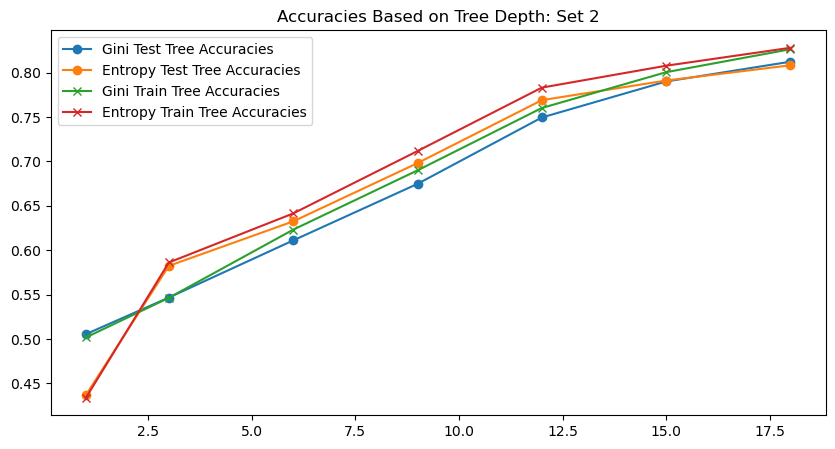

In [90]:
plt.figure(figsize = [10,5])
plt.plot(md, gini_acc, label = 'Gini Test Tree Accuracies', marker = 'o')
plt.plot(md, entropy_acc, label = 'Entropy Test Tree Accuracies', marker = 'o')

plt.plot(md, gini_acc_tr, label = 'Gini Train Tree Accuracies', marker = 'x')
plt.plot(md, entropy_acc_tr, label = 'Entropy Train Tree Accuracies', marker = 'x')


plt.legend()
plt.title('Accuracies Based on Tree Depth: Set 2')
plt.show()


['rolling_14_TMIN_lag_5_pct' 'rolling_3_AWND_lag_5' 'rolling_3_WSFG_lag_5'
 'day_avg_TMIN_lag_5' 'rolling_14_PRCP_lag_5' 'rolling_3_AWND_lag_5_pct'
 'month_avg_WSFG_lag_5' 'day_avg_TMAX_lag_5' 'rolling_14_TMAX_lag_5'
 'rolling_14_TMIN_lag_5']


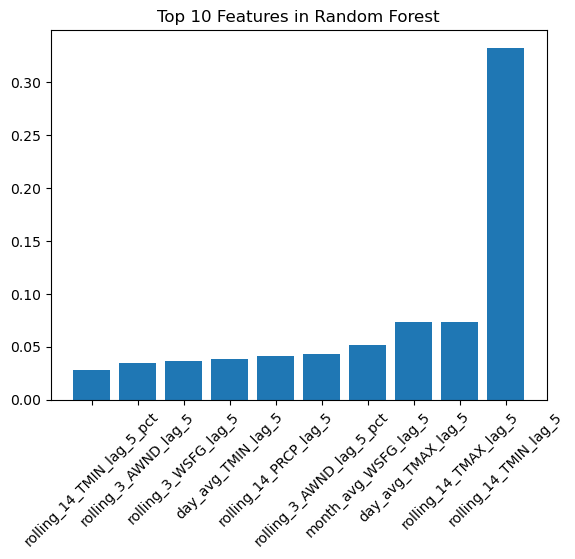

In [91]:
# Display feature importance
feature_importance = entropy_trees[-1].feature_importances_

# Get the indices of the top N features
top_n_indices = np.argsort(feature_importance)[-10:]

# Get the names of the top N features
top_n_features = np.array(feature_names)[top_n_indices]

# Get the corresponding importance values
top_n_importance = feature_importance[top_n_indices]
print(top_n_features)
# Plot feature importance for the top N features
plt.bar(range(len(top_n_importance)), top_n_importance, tick_label=top_n_features)
plt.title('Top 10 Features in Random Forest')
plt.xticks(rotation = 45)
plt.show()

## Random Forests, 2

Gini Test Accuracy: 0.8752921181219461
Gini Train Accuracy: 0.8635039154980878

Entropy Test Accuracy: 0.817505842362439
Entropy Train Accuracy: 0.8369149517392096


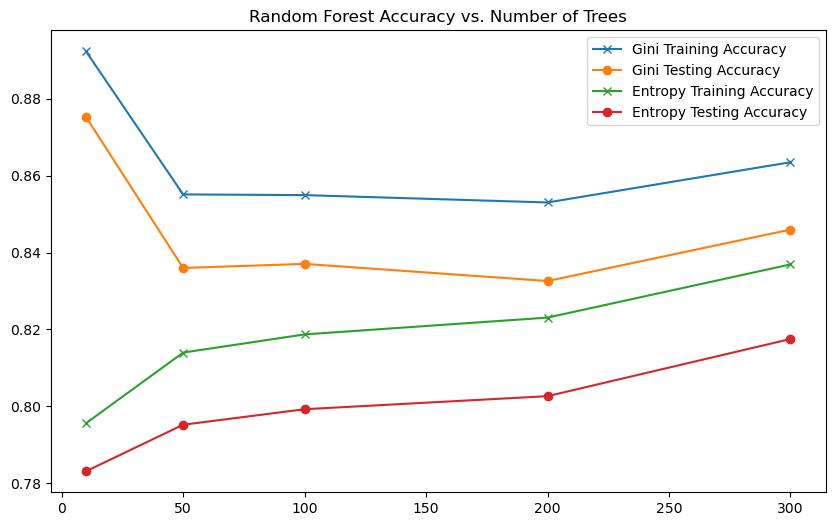

In [92]:
n_trees_values = [10, 50, 100, 200, 300]

# Lists to store accuracy values
gini_train_accuracies = []
gini_test_accuracies = []

entropy_train_accuracies = []
entropy_test_accuracies = []


# Iterate over different number of trees
for n_trees in n_trees_values:
    # Create a Random Forest classifier with the current number of trees
    gini_rf = RandomForestClassifier(n_estimators = n_trees, criterion = 'gini', max_depth=7, random_state=0, class_weight = 'balanced')
    gini_rf.fit(X_train, y_train)

    
    entropy_rf = RandomForestClassifier(n_estimators = n_trees, criterion = 'entropy', max_depth=7, random_state=0, class_weight = 'balanced')
    entropy_rf.fit(X_train, y_train)
   
    #GINI TREES
    # Make predictions on the training set
    gini_train_predictions = gini_rf.predict(X_train)
    gini_train_accuracy = accuracy_score(y_train, gini_train_predictions)
    gini_train_accuracies.append(gini_train_accuracy)
    # Make predictions on the test set
    gini_test_predictions = gini_rf.predict(X_test)
    gini_test_accuracy = accuracy_score(y_test, gini_test_predictions)
    gini_test_accuracies.append(gini_test_accuracy)
    
    #ENTROPY TREES
    # Make predictions on the training set
    entropy_train_predictions = entropy_rf.predict(X_train)
    entropy_train_accuracy = accuracy_score(y_train, entropy_train_predictions)
    entropy_train_accuracies.append(entropy_train_accuracy)
    # Make predictions on the test set
    entropy_test_predictions = entropy_rf.predict(X_test)
    entropy_test_accuracy = accuracy_score(y_test, entropy_test_predictions)
    entropy_test_accuracies.append(entropy_test_accuracy)

    
    
    
    
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_trees_values, gini_train_accuracies, label='Gini Training Accuracy', marker='x')
plt.plot(n_trees_values, gini_test_accuracies, label='Gini Testing Accuracy', marker='o')

plt.plot(n_trees_values, entropy_train_accuracies, label='Entropy Training Accuracy', marker='x')
plt.plot(n_trees_values, entropy_test_accuracies, label='Entropy Testing Accuracy', marker='o')
plt.title('Random Forest Accuracy vs. Number of Trees')
plt.legend()

print(f"Gini Test Accuracy: {max(gini_test_accuracies)}")
print(f"Gini Train Accuracy: {gini_train_accuracies[-1]}")
print()
print(f"Entropy Test Accuracy: {max(entropy_test_accuracies)}")
print(f"Entropy Train Accuracy: {entropy_train_accuracies[-1]}")

['month_avg_TMAX_lag_5' 'TMAX_lag_5' 'day_avg_TMIN_lag_5'
 'rolling_3_TMIN_lag_5' 'month_avg_SNOW_lag_5' 'month_avg_WSFG_lag_5'
 'TMIN_lag_5' 'rolling_3_TMAX_lag_5' 'rolling_14_TMIN_lag_5'
 'rolling_14_TMAX_lag_5']


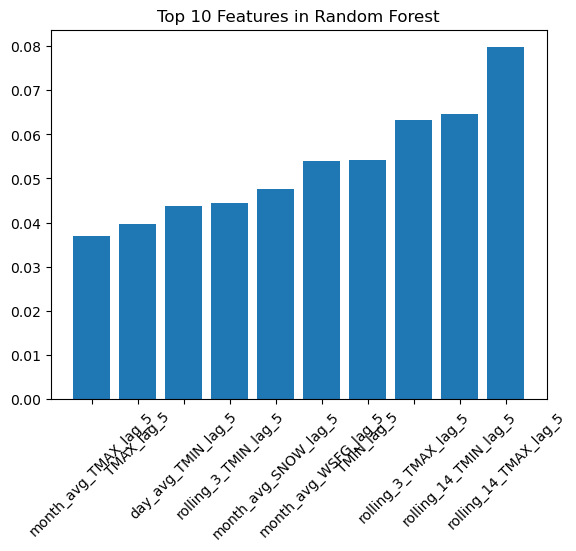

In [93]:
gini_rf2 = RandomForestClassifier(n_estimators = 300, criterion = 'gini',min_samples_leaf=3, max_depth=7, random_state=0, class_weight = 'balanced')
gini_rf2.fit(X_train, y_train)

# Display feature importance
feature_importance = gini_rf2.feature_importances_

# Get the indices of the top N features
top_n_indices = np.argsort(feature_importance)[-10:]

# Get the names of the top N features
top_n_features = np.array(feature_names)[top_n_indices]

# Get the corresponding importance values
top_n_importance = feature_importance[top_n_indices]
print(top_n_features)
# Plot feature importance for the top N features
plt.bar(range(len(top_n_importance)), top_n_importance, tick_label=top_n_features)
plt.title('Top 10 Features in Random Forest')
plt.xticks(rotation = 45)
plt.show()



## Adaboost, 2
using the entropy_trees list and the gini_trees list

base estimator depths : 1, 3, 6, 9, 12, 15, 18

In [95]:
gini_ada = []
entropy_ada = []

ada_gini_acc = []
tr_ada_gini_acc = []

ada_entropy_acc= []
tr_ada_entropy_acc= []

for j, tree_instance in enumerate(entropy_trees):
    # Create adaboost classifer object
    
    abc_entropy = AdaBoostClassifier(estimator=entropy_trees[j])
    abc_entropy.fit(X_train, y_train)
    entropy_ada.append(abc_entropy)
    
    tr_ada_entropy_pred = abc_entropy.predict(X_train)
    ada_entropy_pred = abc_entropy.predict(X_test)
    
    entropy_train_accuracy = accuracy_score(y_train, tr_ada_entropy_pred)
    tr_ada_entropy_acc.append(entropy_train_accuracy)
    
    entropy_test_accuracy = accuracy_score(y_test, ada_entropy_pred)
    ada_entropy_acc.append(entropy_test_accuracy)
    
    
for k, tree_instance in enumerate(gini_trees):
    # Create adaboost classifer object
    abc_gini = AdaBoostClassifier(estimator=gini_trees[k])
    abc_gini.fit(X_train, y_train)
    gini_ada.append(abc_gini)
    
    tr_ada_gini_pred = abc_gini.predict(X_train)
    ada_gini_pred = abc_gini.predict(X_test)
    
    gini_train_accuracy = accuracy_score(y_train, tr_ada_gini_pred)
    tr_ada_gini_acc.append(gini_train_accuracy)
    
    gini_test_accuracy = accuracy_score(y_test, ada_gini_pred)
    ada_gini_acc.append(gini_test_accuracy)

    

Gini Test Accuracy 0.9904397705544933
Entropy Test Accuracy 0.9906522200977268


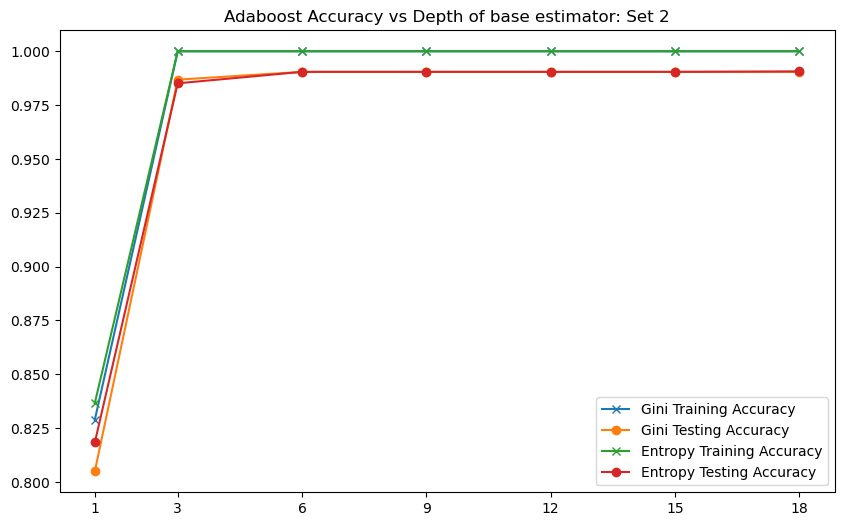

In [96]:
# Plot the results
print(f"Gini Test Accuracy {(max(ada_gini_acc))}")
print(f"Entropy Test Accuracy {max(ada_entropy_acc)}")
plt.figure(figsize=(10, 6))
plt.plot(md, tr_ada_gini_acc, label='Gini Training Accuracy', marker='x')
plt.plot(md, ada_gini_acc, label='Gini Testing Accuracy', marker='o')

plt.plot(md, tr_ada_entropy_acc, label='Entropy Training Accuracy', marker='x')
plt.plot(md, ada_entropy_acc, label='Entropy Testing Accuracy', marker='o')
plt.title('Adaboost Accuracy vs Depth of base estimator: Set 2')
plt.xticks(md)
plt.legend()


/Users/ianadler/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ianadler/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ianadler/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ianadler/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ianadler/miniconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ianadler

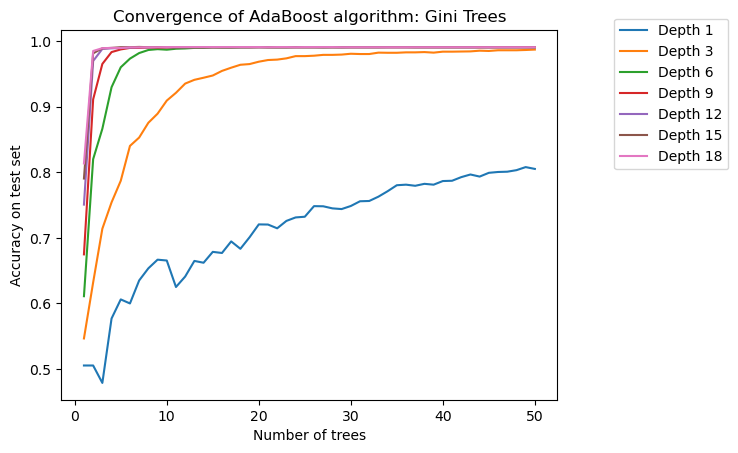

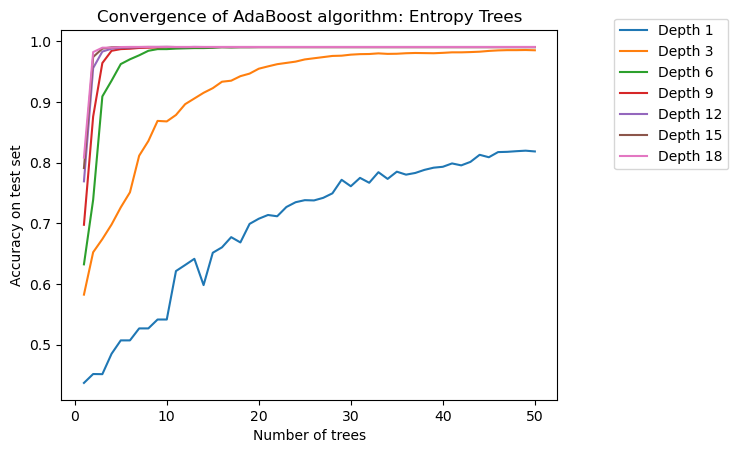

In [97]:
boosting_acc_gini = pd.DataFrame(
    {
        "Number of trees": range(1, 51)
    }
).set_index("Number of trees")
for k, ada_tree in enumerate(gini_ada):
    boosting_acc_gini[f' Gini {k}'] =[ accuracy_score(y_test, y_pred)
            for y_pred in ada_tree.staged_predict(X_test)]
    
boosting_acc_entropy = pd.DataFrame(
    {
        "Number of trees": range(1, 51)
    }
).set_index("Number of trees")
for k, ada_tree in enumerate(entropy_ada):
    boosting_acc_entropy[f' Entropy {k}'] =[ accuracy_score(y_test, y_pred)
            for y_pred in ada_tree.staged_predict(X_test)]
    

    
#Plotting
ax = boosting_acc_gini.plot()
ax.set_ylabel("Accuracy on test set")
ax.set_title("Convergence of AdaBoost algorithm: Gini Trees")

plt.legend(["Depth 1","Depth 3","Depth 6","Depth 9","Depth 12","Depth 15","Depth 18"], bbox_to_anchor=(1.1, 1.05))

ax2 = boosting_acc_entropy.plot()
ax2.set_ylabel("Accuracy on test set")
ax2.set_title("Convergence of AdaBoost algorithm: Entropy Trees")

plt.legend(["Depth 1","Depth 3","Depth 6","Depth 9","Depth 12","Depth 15","Depth 18"], bbox_to_anchor=(1.1, 1.05))



10 Most important features: Index(['rolling_3_AWND_lag_5_pct', 'rolling_3_WSFG_lag_5',
       'rolling_14_TMAX_lag_5', 'day_avg_WSFG_lag_5', 'day_avg_AWND_lag_5',
       'rolling_3_AWND_lag_5', 'day_avg_PRCP_lag_5', 'rolling_14_AWND_lag_5',
       'rolling_14_WSFG_lag_5_pct', 'rolling_14_TMIN_lag_5_pct'],
      dtype='object')


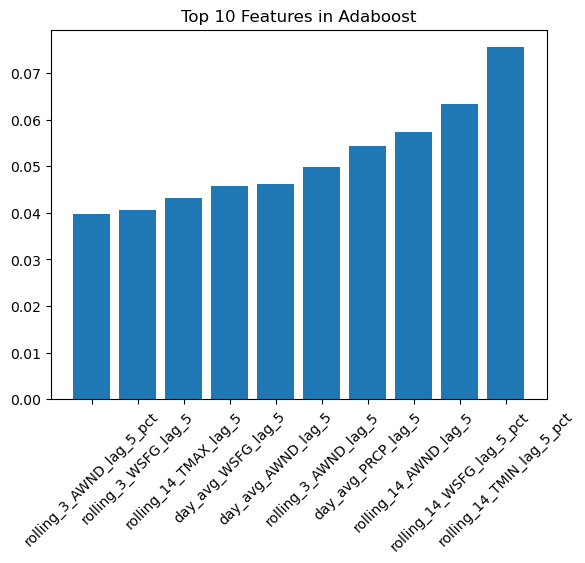

In [99]:
# Retrieve feature importances
feature_importances = gini_ada[-1].feature_importances_

# Get the indices of the top ten features
top_ten_indices = np.argsort(feature_importances)[-10:]



# Select only the top ten features from your original dataset
print(f"10 Most important features: {feature_names[top_ten_indices]}")
plt.bar(range(len(top_ten_indices)), feature_importances[top_ten_indices], tick_label=feature_names[top_ten_indices])
plt.title('Top 10 Features in Adaboost')
plt.xticks(rotation = 45)
plt.show()

## SVM Classifier, 2

For the SVM we need to rescale the data, because SVM relies on the distance between points

In [100]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


In [101]:
C = 10.0 # SVM regularization parameter


models = (
    svm.SVC(kernel="linear", C=C, class_weight = 'balanced'),
    svm.LinearSVC(C=C, max_iter=10000, dual="auto", class_weight = 'balanced'),
    svm.SVC(kernel="rbf", gamma=0.7, C=C, class_weight = 'balanced'),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C, class_weight = 'balanced'),
    svm.SVC(kernel='sigmoid',degree=3, gamma="auto", C=C, class_weight = 'balanced')
         )

models = (clf.fit(X_train_std, y_train) for clf in models)
# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
    "SVC with Sigmoid (degree 3) kernel"
)

y_train_prediction = [] # a 2d list of the predicted classifications of the different models
y_test_prediction = [] # a 2d list of the predicted classifications of the different models

for clf in models:
    
    y_train_prediction.append(clf.predict(X_train_std)) 
        
    y_test_prediction.append(clf.predict(X_test_std)) 


In [102]:

train_accuracy = [] # a 1d array, length equal to the number of models, of the accuracy of each model
for y_hat in y_train_prediction:
    train_accuracy.append(accuracy_score(y_train, y_hat))
    

test_accuracy = [] # a 1d array, length equal to the number of models, of the accuracy of each model
for y_hat in y_test_prediction:
    test_accuracy.append(accuracy_score(y_test, y_hat))


for i in range(len(train_accuracy)):
    print(titles[i], " train accuracy = ", train_accuracy[i])

print('\n')

for i in range(len(test_accuracy)):
    print(titles[i], " test accuracy = ", test_accuracy[i])


SVC with linear kernel  train accuracy =  0.6811145510835913
LinearSVC (linear kernel)  train accuracy =  0.7009652158076853
SVC with RBF kernel  train accuracy =  1.0
SVC with polynomial (degree 3) kernel  train accuracy =  0.9898925514478237
SVC with Sigmoid (degree 3) kernel  train accuracy =  0.6311236568930978


SVC with linear kernel  test accuracy =  0.6738899511366051
LinearSVC (linear kernel)  test accuracy =  0.691523263224984
SVC with RBF kernel  test accuracy =  0.9904397705544933
SVC with polynomial (degree 3) kernel  test accuracy =  0.9638835776503081
SVC with Sigmoid (degree 3) kernel  test accuracy =  0.6267261525387721


([0, 1, 2, 3, 4],
 [Text(0, 0, 'SVC with linear kernel'),
  Text(1, 0, 'LinearSVC (linear kernel)'),
  Text(2, 0, 'SVC with RBF kernel'),
  Text(3, 0, 'SVC with polynomial (degree 3) kernel'),
  Text(4, 0, 'SVC with Sigmoid (degree 3) kernel')])

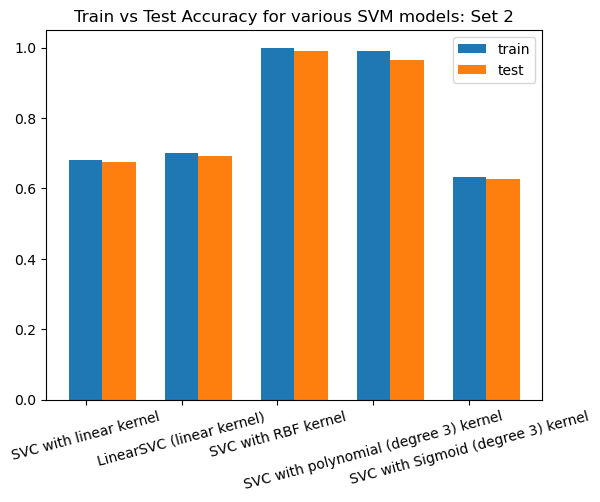

In [103]:
width = 0.35
x = range(len(titles))

plt.bar(titles, train_accuracy, width, label='train')
plt.bar([i + width for i in x], test_accuracy, width, label='test')
plt.legend()
plt.title('Train vs Test Accuracy for various SVM models: Set 2')
plt.xticks(rotation=15)


### Plots

We can get an idea of the weights of different features 

59 61 4
The parameters/features with the largest weights are: ['month_avg_TMAX_lag_5', 'month_avg_TMIN_lag_5', 'TMAX_lag_5', 'rolling_14_TMAX_lag_5', 'rolling_14_TMIN_lag_5']


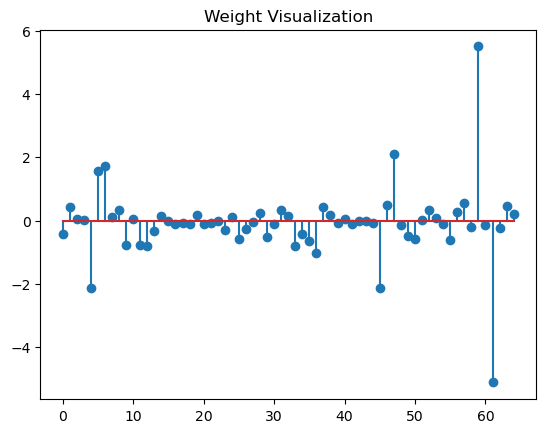

In [104]:
test_SVM = svm.SVC(kernel="linear", C=C, class_weight = 'balanced')
test_SVM.fit(X_train_std, y_train)

x_labels1 = X_train.columns
W = test_SVM.coef_
W=W.flatten()
plt.stem(W)
plt.title("Weight Visualization")
idx1=np.argsort(np.abs(W))[-1]
idx2=np.argsort(np.abs(W))[-2]
idx3=np.argsort(np.abs(W))[-3]
idx4=np.argsort(np.abs(W))[-4]
idx5=np.argsort(np.abs(W))[-5]
print(idx1, idx2, idx3)
heavy=[x_labels1[idx1], x_labels1[idx2],x_labels1[idx3], x_labels1[idx4],x_labels1[idx5]]
print("The parameters/features with the largest weights are: " + str(heavy))

## Accuracies, 2

The most accurate versions of each model are:

SVM: RBF Kernel; test_accuracy

Ada: Gini and Entropy are the same: ada_gini_acc[-1]

Random Forest: 300 Gini Trees ; gini_test_accuracies[-1]

Decision Tree: Entropy Tree depth 18; entropy_acc[-1]




([0, 1, 2, 3],
 [Text(0, 0, 'Entropy Tree depth 18'),
  Text(1, 0, 'Random Forest Gini 300'),
  Text(2, 0, 'Adaboost'),
  Text(3, 0, ' SVM Classifier(RBF Kernel)')])

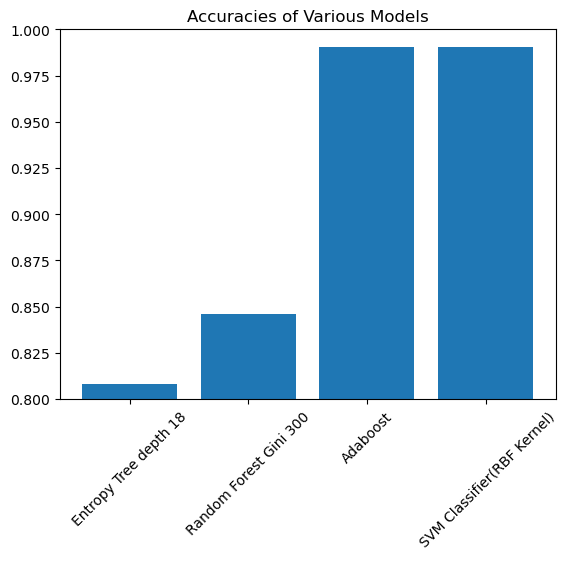

In [105]:

models_2 = ['Entropy Tree depth 18', "Random Forest Gini 300", 'Adaboost', ' SVM Classifier(RBF Kernel)']

acc_2 = [entropy_acc[-1], gini_test_accuracies[-1],ada_entropy_acc[-1], max(test_accuracy)]
plt.ylim(0.8, 1)
plt.bar(models_2, acc_2)
plt.title("Accuracies of Various Models")
plt.xticks(rotation=45)

The versions of the models that are the most accurate for the 2 datasets are almost exactly the same, the only difference is the Random forest with 100 gini trees was more accurate than 300 for the first data set.  
Lets plot them together 

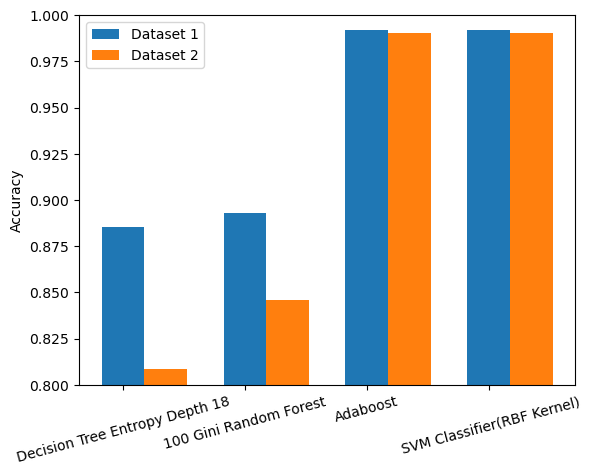

In [106]:
width = 0.35
x = range(len(models_1))

plt.bar(models_1, acc_1, width, label='Dataset 1')
plt.bar([i + width for i in x], acc_2, width, label='Dataset 2')
plt.ylim(0.80, 1)
plt.xticks(rotation=15)
plt.ylabel('Accuracy')
plt.legend()

### Final Conclusion
Above we have the a plot of the 2 datasets accuracy in each classification model. We can see that the first dataset is more accurate in each model, but for the most successful models, only slighty. To me this is a result of the amount of features in the first dataset. The first dataset has ~160 features while the second has only ~60. In that context, its impressive how close the accuracies of Adaboost and SVM models are. In each model trained with the second dataset, the most influential features were the rolling windows or expanding windows and the percentage difference between days. I think that shows the power of those features that combine/compare multiple days of data. In future tests, I will definitely combine multiple lags and expanding and rolling windows, as well as percentage difference. I think in future additionals I will also more heavily examine the precision and recall metrics, because the model needs to reduce false positives as much as possible, and accuracy alone doesn't track those errors as closely. I would also like to eventually as some location parameters. Right now the model can understand temporal relationships, that one days weather will influence the next, but not spacial relationships, that the weather in one location will influence another. I would have to rework the model to analysis image data, i.e. maps with data on it; there is lots of publically available datasets of that type of data as well.